# TODO:

*  Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* action repeat Wrapper (4 Times)
* better reward handling for different games
* Explanations
* Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [2]:
# Hier kann das Spiel übergeben werden
game = "Breakout-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [3]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [4]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [5]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [6]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [7]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [8]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [9]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

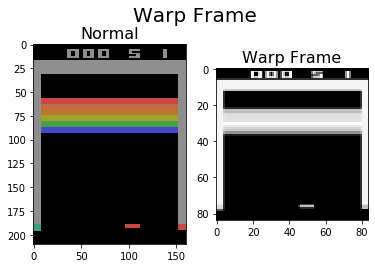

In [10]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [11]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

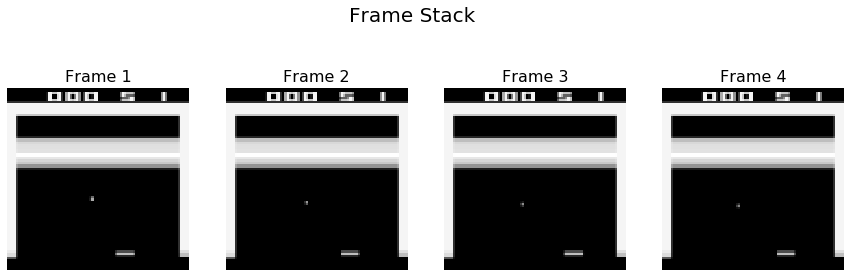

In [12]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
    axs[i].axis("off")
plt.show()

### Erstellen des Environments

In [13]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    #env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)

# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [14]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "mean_squared_error"#Huber()################################################################### MSE probieren
OPTIMIZER = Adam(lr=0.00005)#RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01) # Adam probieren mit 0.00005#############################

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    net_output = Dense(OUTPUT_SHAPE)(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [15]:
DQN.summary()
TARGET.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0     

# **Memory Buffer**

In [16]:
MEMORY_SIZE = 25000#1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 32#50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
    MEMORY_BUFFER.append([state, action, reward, next_state, done])

# **Experience Replay**

In [17]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

    # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
    minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.concatenate(states)
    next_states = np.concatenate(next_states)

    q_values = DQN.predict(states)
    q_values_next = TARGET.predict(next_states)

    # Q-Values Update
    for i in range(MINIBATCH_SIZE):
        a = actions[i]
        done = dones[i]
        if done:
            q_values[i][a] = rewards[i]
        else:
            q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(states, q_values, batch_size=MINIBATCH_SIZE, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [18]:
def linear(epsilon, decay, epsilon_min, decay_step):
    return epsilon - decay

def exponential(epsilon, decay, epsilon_min, decay_step):
    epsilon = 1
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-decay * decay_step)

def epsilon_decay(mode, epsilon, decay, epsilon_min, decay_step):
    decay_strategy = {
        "linear": linear,
        "exponential": exponential
    }
    strategy = decay_strategy.get(mode)
    return strategy(epsilon, decay, epsilon_min, decay_step)

In [19]:
EPSILON = 1.0
EPSILON_MIN = 0.02 #0.1
#EPSILON_STEPS = 1000000
EPSILON_DECAY = 0.00002 #0.0000009

def get_action(state):
    if np.random.rand() <= EPSILON:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(DQN(state))

In [20]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

1.0

# **Training des Agenten**

In [21]:
from datetime import datetime
start_time = datetime.now()

EPISODES = 15000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
EPSILON_LIST = []
STEPS = 0
SYNC = 1000 #10000

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        save_transition(state, action, reward, next_state, done)
        
        # Experience Replay, falls genügend Transitionen gespeichert
        if len(MEMORY_BUFFER) > TRAIN_START:
            replay()
            
        # Synchronisation zwischen Target Networks und Deep Q-Network (alle 1000 Updates - Algorithm 1)
        if STEPS % SYNC == 0:
            TARGET.set_weights(DQN.get_weights())

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # State aktualisieren
        state = next_state
        STEPS += 1
        
        # EPSILON verringern
        if EPSILON > EPSILON_MIN:
            EPSILON = epsilon_decay("exponential", EPSILON, EPSILON_DECAY, EPSILON_MIN, STEPS)

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            EPSILON_LIST.append(EPSILON)
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD, "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # Trainierte Gewichte speichern
                if EPSILON < 0.3:
                    import os
                    PATH = "WEIGHTS"
                    try:
                        os.makedirs(PATH)
                    except FileExistsError:
                        # Pfad existiert bereits
                        pass
                    DQN.save_weights(PATH +"/" + game + "_DQN"+ "_Ep_"+ str(episode+1)+ ".h5")
                    #TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_Ep_"+ str(episode+1)+ ".h5")
                    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

W0118 21:08:32.329788 140509834082112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 1 	Reward: 0.0 	Mean: 0.0 	BestMean: 1.0 	TRAIN START: True 	Epsi: 0.9990596514395278
Episode: 2 	Reward: 3.0 	Mean: 1.5 	BestMean: 1.0 	TRAIN START: True 	Epsi: 0.9972402930157055
Episode: 3 	Reward: 1.0 	Mean: 1.33 	BestMean: 1.5 	TRAIN START: True 	Epsi: 0.9961073515089216
Episode: 4 	Reward: 2.0 	Mean: 1.5 	BestMean: 1.5 	TRAIN START: True 	Epsi: 0.9946442880535742
Episode: 5 	Reward: 2.0 	Mean: 1.6 	BestMean: 1.5 	TRAIN START: True 	Epsi: 0.99328074075612
Episode: 6 	Reward: 6.0 	Mean: 2.33 	BestMean: 1.6 	TRAIN START: True 	Epsi: 0.9908699950792715
Episode: 7 	Reward: 2.0 	Mean: 2.29 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.9894923380542391
Episode: 8 	Reward: 0.0 	Mean: 2.0 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.9885039600279095
Episode: 9 	Reward: 1.0 	Mean: 1.89 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.9872650680191095
Episode: 10 	Reward: 0.0 	Mean: 1.7 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.9864

Episode: 76 	Reward: 2.0 	Mean: 1.4 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.9057657912200482
Episode: 77 	Reward: 1.0 	Mean: 1.5 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.904721204014067
Episode: 78 	Reward: 2.0 	Mean: 1.4 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.9033951170219313
Episode: 79 	Reward: 0.0 	Mean: 1.1 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.9026886835393833
Episode: 80 	Reward: 0.0 	Mean: 1.1 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.9019122591746943
Episode: 81 	Reward: 0.0 	Mean: 1.0 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.9009603080809059
Episode: 82 	Reward: 2.0 	Mean: 1.1 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.8996574511768699
Episode: 83 	Reward: 1.0 	Mean: 1.1 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.8984092240472046
Episode: 84 	Reward: 1.0 	Mean: 1.1 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.8974610541891191
Ep

Episode: 150 	Reward: 0.0 	Mean: 1.3 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.821586245731351
Episode: 151 	Reward: 4.0 	Mean: 1.3 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.8198246944076903
Episode: 152 	Reward: 2.0 	Mean: 1.3 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.818577940605222
Episode: 153 	Reward: 4.0 	Mean: 1.5 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.8170302011931002
Episode: 154 	Reward: 3.0 	Mean: 1.6 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.8156445744878513
Episode: 155 	Reward: 1.0 	Mean: 1.6 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.8146109085694387
Episode: 156 	Reward: 0.0 	Mean: 1.6 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.8136738206879104
Episode: 157 	Reward: 2.0 	Mean: 1.7 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.8123257214018014
Episode: 158 	Reward: 2.0 	Mean: 1.9 	BestMean: 2.3333333333333335 	TRAIN START: True 	Epsi: 0.81107483522

Episode: 231 	Reward: 2.0 	Mean: 2.4 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7277370112594759
Episode: 232 	Reward: 1.0 	Mean: 2.3 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7270013473792916
Episode: 233 	Reward: 2.0 	Mean: 2.1 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7260404790853975
Episode: 234 	Reward: 3.0 	Mean: 2.3 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7247425590564934
Episode: 235 	Reward: 1.0 	Mean: 2.0 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7240381687512887
Episode: 236 	Reward: 2.0 	Mean: 2.0 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7229829031452286
Episode: 237 	Reward: 3.0 	Mean: 2.1 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7218028833621031
Episode: 238 	Reward: 2.0 	Mean: 2.1 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7208911323802754
Episode: 239 	Reward: 5.0 	Mean: 2.3 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.719336879924948
Episode: 240 	Reward: 2.0 	Mean: 2.3 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7183864282219045
Episode: 241 	Reward: 1.0 	Mean

Episode: 316 	Reward: 2.0 	Mean: 3.4 	BestMean: 3.4 	TRAIN START: True 	Epsi: 0.6426549865109107
Episode: 317 	Reward: 2.0 	Mean: 3.3 	BestMean: 3.4 	TRAIN START: True 	Epsi: 0.6417465735334428
Episode: 318 	Reward: 1.0 	Mean: 3.0 	BestMean: 3.4 	TRAIN START: True 	Epsi: 0.640938828136115
Episode: 319 	Reward: 7.0 	Mean: 3.3 	BestMean: 3.4 	TRAIN START: True 	Epsi: 0.6393760322390738
Episode: 320 	Reward: 3.0 	Mean: 3.4 	BestMean: 3.4 	TRAIN START: True 	Epsi: 0.6384105588937882
Episode: 321 	Reward: 2.0 	Mean: 3.4 	BestMean: 3.4 	TRAIN START: True 	Epsi: 0.637508338259131
Episode: 322 	Reward: 4.0 	Mean: 3.6 	BestMean: 3.4 	TRAIN START: True 	Epsi: 0.6363854951806429
Episode: 323 	Reward: 2.0 	Mean: 3.6 	BestMean: 3.6 	TRAIN START: True 	Epsi: 0.6356216508479791
Episode: 324 	Reward: 1.0 	Mean: 3.3 	BestMean: 3.6 	TRAIN START: True 	Epsi: 0.6350063369053786
Episode: 325 	Reward: 3.0 	Mean: 2.7 	BestMean: 3.6 	TRAIN START: True 	Epsi: 0.6340845189363381
Episode: 326 	Reward: 5.0 	Mean:

Episode: 401 	Reward: 3.0 	Mean: 3.7 	BestMean: 5.6 	TRAIN START: True 	Epsi: 0.5549068243658862
Episode: 402 	Reward: 7.0 	Mean: 4.1 	BestMean: 5.6 	TRAIN START: True 	Epsi: 0.5534858629296293
Episode: 403 	Reward: 5.0 	Mean: 4.4 	BestMean: 5.6 	TRAIN START: True 	Epsi: 0.552345423887964
Episode: 404 	Reward: 8.0 	Mean: 5.0 	BestMean: 5.6 	TRAIN START: True 	Epsi: 0.5511011919152173
Episode: 405 	Reward: 6.0 	Mean: 5.4 	BestMean: 5.6 	TRAIN START: True 	Epsi: 0.549859868041484
Episode: 406 	Reward: 9.0 	Mean: 5.6 	BestMean: 5.6 	TRAIN START: True 	Epsi: 0.5480719649458784
Episode: 407 	Reward: 7.0 	Mean: 5.8 	BestMean: 5.6 	TRAIN START: True 	Epsi: 0.5468587951066236
Episode: 408 	Reward: 5.0 	Mean: 5.6 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.5455853383266587
Episode: 409 	Reward: 3.0 	Mean: 5.5 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.5448080473631298
Episode: 410 	Reward: 1.0 	Mean: 5.4 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.5441891390949335
Episode: 411 	Reward: 8.0 	Mean:

Episode: 486 	Reward: 4.0 	Mean: 5.6 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.47312705993616155
Episode: 487 	Reward: 1.0 	Mean: 5.3 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.4726469997294884
Episode: 488 	Reward: 9.0 	Mean: 5.6 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.4716432379778781
Episode: 489 	Reward: 2.0 	Mean: 5.1 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.4710113798486031
Episode: 490 	Reward: 6.0 	Mean: 5.4 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.4699122535611563
Episode: 491 	Reward: 4.0 	Mean: 5.4 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.4689953681050327
Episode: 492 	Reward: 5.0 	Mean: 5.4 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.46805346717413804
Episode: 493 	Reward: 1.0 	Mean: 4.9 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.4675787821264551
Episode: 494 	Reward: 4.0 	Mean: 4.7 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.4667470593336829
Episode: 495 	Reward: 5.0 	Mean: 4.1 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.465792042858803
Episode: 496 	Reward: 6.0 	Me

Episode: 571 	Reward: 6.0 	Mean: 4.6 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.3971234440553759
Episode: 572 	Reward: 6.0 	Mean: 4.6 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.396279632961942
Episode: 573 	Reward: 2.0 	Mean: 4.1 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.39576824048681947
Episode: 574 	Reward: 2.0 	Mean: 3.8 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.39522001915466354
Episode: 575 	Reward: 5.0 	Mean: 4.0 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.39437297942679483
Episode: 576 	Reward: 6.0 	Mean: 4.3 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.3934158102986881
Episode: 577 	Reward: 6.0 	Mean: 4.6 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.3924536392424962
Episode: 578 	Reward: 4.0 	Mean: 4.6 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.3917986973553524
Episode: 579 	Reward: 5.0 	Mean: 4.8 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.3909890590215453
Episode: 580 	Reward: 7.0 	Mean: 4.9 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.39013676469998526
Episode: 581 	Reward: 5.0 	

Episode: 656 	Reward: 6.0 	Mean: 5.1 	BestMean: 6.7 	TRAIN START: True 	Epsi: 0.33265882237315497
Episode: 657 	Reward: 3.0 	Mean: 4.8 	BestMean: 6.7 	TRAIN START: True 	Epsi: 0.3322214062845392
Episode: 658 	Reward: 12.0 	Mean: 5.1 	BestMean: 6.7 	TRAIN START: True 	Epsi: 0.3312114459474366
Episode: 659 	Reward: 11.0 	Mean: 6.0 	BestMean: 6.7 	TRAIN START: True 	Epsi: 0.3302730051395414
Episode: 660 	Reward: 6.0 	Mean: 6.2 	BestMean: 6.7 	TRAIN START: True 	Epsi: 0.32959734672359386
Episode: 661 	Reward: 5.0 	Mean: 6.3 	BestMean: 6.7 	TRAIN START: True 	Epsi: 0.32892933816363734
Episode: 662 	Reward: 3.0 	Mean: 5.5 	BestMean: 6.7 	TRAIN START: True 	Epsi: 0.3284046044387986
Episode: 663 	Reward: 11.0 	Mean: 6.3 	BestMean: 6.7 	TRAIN START: True 	Epsi: 0.3273578093437807
Episode: 664 	Reward: 8.0 	Mean: 6.8 	BestMean: 6.7 	TRAIN START: True 	Epsi: 0.326467762887819
Episode: 665 	Reward: 6.0 	Mean: 7.1 	BestMean: 6.8 	TRAIN START: True 	Epsi: 0.32576369701930147
Episode: 666 	Reward: 8.

Episode: 741 	Reward: 5.0 	Mean: 6.2 	BestMean: 7.6 	TRAIN START: True 	Epsi: 0.27469648253558254
Episode: 742 	Reward: 12.0 	Mean: 7.0 	BestMean: 7.6 	TRAIN START: True 	Epsi: 0.2737000266535664
Episode: 743 	Reward: 6.0 	Mean: 7.2 	BestMean: 7.6 	TRAIN START: True 	Epsi: 0.2730665687392514
Episode: 744 	Reward: 7.0 	Mean: 7.1 	BestMean: 7.6 	TRAIN START: True 	Epsi: 0.2724144985241848
Episode: 745 	Reward: 9.0 	Mean: 7.3 	BestMean: 7.6 	TRAIN START: True 	Epsi: 0.2718648342691255
Episode: 746 	Reward: 4.0 	Mean: 6.9 	BestMean: 7.6 	TRAIN START: True 	Epsi: 0.27134652675056603
Episode: 747 	Reward: 8.0 	Mean: 7.2 	BestMean: 7.6 	TRAIN START: True 	Epsi: 0.2705685589906895
Episode: 748 	Reward: 7.0 	Mean: 7.1 	BestMean: 7.6 	TRAIN START: True 	Epsi: 0.2699329224509979
Episode: 749 	Reward: 6.0 	Mean: 6.7 	BestMean: 7.6 	TRAIN START: True 	Epsi: 0.2693188430890638
Episode: 750 	Reward: 7.0 	Mean: 7.1 	BestMean: 7.6 	TRAIN START: True 	Epsi: 0.2686863767998398
Episode: 751 	Reward: 8.0 	

Episode: 825 	Reward: 8.0 	Mean: 7.3 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.22441506756102117
Episode: 826 	Reward: 8.0 	Mean: 7.4 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.22377421092035452
Episode: 827 	Reward: 8.0 	Mean: 7.5 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.2231881854746065
Episode: 828 	Reward: 4.0 	Mean: 6.8 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.2227943825071739
Episode: 829 	Reward: 10.0 	Mean: 7.3 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.22212626404667743
Episode: 830 	Reward: 7.0 	Mean: 7.6 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.22155303982046914
Episode: 831 	Reward: 8.0 	Mean: 8.0 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.2209814412415515
Episode: 832 	Reward: 4.0 	Mean: 7.5 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.22057988005410953
Episode: 833 	Reward: 7.0 	Mean: 7.5 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.2200510475368354
Episode: 834 	Reward: 10.0 	Mean: 7.4 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.21948769827856718
Episode: 835 	Reward: 

Episode: 909 	Reward: 10.0 	Mean: 8.0 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.18228151461927167
Episode: 910 	Reward: 9.0 	Mean: 7.8 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.18177274984208538
Episode: 911 	Reward: 5.0 	Mean: 7.4 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.1814495276723117
Episode: 912 	Reward: 10.0 	Mean: 7.5 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.18086291966584955
Episode: 913 	Reward: 4.0 	Mean: 7.5 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.18057041541166993
Episode: 914 	Reward: 5.0 	Mean: 7.2 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.1802431856520682
Episode: 915 	Reward: 5.0 	Mean: 7.2 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.17987185237451267
Episode: 916 	Reward: 15.0 	Mean: 8.0 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.17921771966815586
Episode: 917 	Reward: 1.0 	Mean: 7.1 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.17904903830222577
Episode: 918 	Reward: 11.0 	Mean: 7.5 	BestMean: 8.9 	TRAIN START: True 	Epsi: 0.1784870001011881
Episode: 919 	Rewar

Episode: 993 	Reward: 7.0 	Mean: 7.3 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.14749186666035996
Episode: 994 	Reward: 7.0 	Mean: 7.2 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.14718116571501105
Episode: 995 	Reward: 11.0 	Mean: 7.4 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.14670386242443573
Episode: 996 	Reward: 17.0 	Mean: 8.2 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.14620310727880992
Episode: 997 	Reward: 11.0 	Mean: 8.8 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.14573198919754993
Episode: 998 	Reward: 4.0 	Mean: 8.3 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.14550838532326532
Episode: 999 	Reward: 7.0 	Mean: 8.0 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.14518248737235018
Episode: 1000 	Reward: 8.0 	Mean: 8.2 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.1447925266667852
Episode: 1001 	Reward: 12.0 	Mean: 9.1 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.14434656816333774
Episode: 1002 	Reward: 8.0 	Mean: 9.2 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.1439740874592643
Episo

Episode: 1075 	Reward: 10.0 	Mean: 9.4 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.1197884626239909
Episode: 1076 	Reward: 13.0 	Mean: 10.0 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.11937420487301185
Episode: 1077 	Reward: 2.0 	Mean: 9.6 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.11924510234150436
Episode: 1078 	Reward: 10.0 	Mean: 9.2 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.11890428573011173
Episode: 1079 	Reward: 13.0 	Mean: 9.6 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.11848384963760383
Episode: 1080 	Reward: 8.0 	Mean: 9.7 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.11820651640527205
Episode: 1081 	Reward: 8.0 	Mean: 9.0 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.11792213006719439
Episode: 1082 	Reward: 11.0 	Mean: 9.3 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.11761708913269171
Episode: 1083 	Reward: 9.0 	Mean: 9.3 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.11732273022917787
Episode: 1084 	Reward: 11.0 	Mean: 9.5 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.116965240765

Episode: 1157 	Reward: 12.0 	Mean: 7.4 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.09783666336548473
Episode: 1158 	Reward: 2.0 	Mean: 7.1 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.0977402057190118
Episode: 1159 	Reward: 8.0 	Mean: 7.3 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.09752593857590157
Episode: 1160 	Reward: 4.0 	Mean: 7.5 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.09738651740316415
Episode: 1161 	Reward: 6.0 	Mean: 7.4 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.09719329274112162
Episode: 1162 	Reward: 5.0 	Mean: 7.2 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.09702519465643071
Episode: 1163 	Reward: 6.0 	Mean: 7.0 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.09685131427534709
Episode: 1164 	Reward: 19.0 	Mean: 7.9 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.09646342880296398
Episode: 1165 	Reward: 7.0 	Mean: 7.7 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.09623743169443584
Episode: 1166 	Reward: 6.0 	Mean: 7.5 	BestMean: 11.6 	TRAIN START: True 	Epsi: 0.09606989370407111

Episode: 1239 	Reward: 9.0 	Mean: 9.9 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.08086586884208938
Episode: 1240 	Reward: 15.0 	Mean: 10.6 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.08067747680720355
Episode: 1241 	Reward: 6.0 	Mean: 10.6 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.08053323612689837
Episode: 1242 	Reward: 7.0 	Mean: 9.5 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.08036277286718271
Episode: 1243 	Reward: 12.0 	Mean: 9.5 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.08013623499928549
Episode: 1244 	Reward: 9.0 	Mean: 9.3 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.07994410661664954
Episode: 1245 	Reward: 8.0 	Mean: 9.7 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.0797753023618564
Episode: 1246 	Reward: 5.0 	Mean: 9.5 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.07963678440333868
Episode: 1247 	Reward: 12.0 	Mean: 9.4 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.07940703012656647
Episode: 1248 	Reward: 4.0 	Mean: 8.7 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.07930019365400

Episode: 1321 	Reward: 9.0 	Mean: 9.5 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.0672528311973185
Episode: 1322 	Reward: 8.0 	Mean: 9.6 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.06711505418255903
Episode: 1323 	Reward: 12.0 	Mean: 9.7 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.06689788468006562
Episode: 1324 	Reward: 5.0 	Mean: 9.4 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.06679669457381414
Episode: 1325 	Reward: 11.0 	Mean: 9.7 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.06662293426455512
Episode: 1326 	Reward: 13.0 	Mean: 9.9 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.06646561476646608
Episode: 1327 	Reward: 1.0 	Mean: 9.3 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.06641917237676466
Episode: 1328 	Reward: 8.0 	Mean: 9.0 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.06627271930976839
Episode: 1329 	Reward: 9.0 	Mean: 8.2 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.06612396078335077
Episode: 1330 	Reward: 10.0 	Mean: 8.6 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.065977519553021

Episode: 1403 	Reward: 9.0 	Mean: 8.4 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.0571109684571699
Episode: 1404 	Reward: 19.0 	Mean: 9.1 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.05694360540518208
Episode: 1405 	Reward: 8.0 	Mean: 9.0 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.056837360887157296
Episode: 1406 	Reward: 11.0 	Mean: 9.7 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.056724810852218824
Episode: 1407 	Reward: 13.0 	Mean: 10.0 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.056576741917018405
Episode: 1408 	Reward: 11.0 	Mean: 10.2 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.056444573480481236
Episode: 1409 	Reward: 12.0 	Mean: 10.8 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.05631215637834429
Episode: 1410 	Reward: 5.0 	Mean: 10.2 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.0562338067686079
Episode: 1411 	Reward: 5.0 	Mean: 9.9 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.05615490310609296
Episode: 1412 	Reward: 4.0 	Mean: 9.7 	BestMean: 11.8 	TRAIN START: True 	Epsi: 0.0560949

Episode: 1484 	Reward: 9.0 	Mean: 10.8 	BestMean: 11.9 	TRAIN START: True 	Epsi: 0.04829011843212169
Episode: 1485 	Reward: 9.0 	Mean: 11.1 	BestMean: 11.9 	TRAIN START: True 	Epsi: 0.048189020880727226
Episode: 1486 	Reward: 8.0 	Mean: 10.5 	BestMean: 11.9 	TRAIN START: True 	Epsi: 0.04811526231193718
Episode: 1487 	Reward: 12.0 	Mean: 11.2 	BestMean: 11.9 	TRAIN START: True 	Epsi: 0.04800358595130981
Episode: 1488 	Reward: 20.0 	Mean: 12.2 	BestMean: 11.9 	TRAIN START: True 	Epsi: 0.04783495407309918
Episode: 1489 	Reward: 5.0 	Mean: 11.4 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.047778784216526274
Episode: 1490 	Reward: 9.0 	Mean: 11.5 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.04768892660360509
Episode: 1491 	Reward: 5.0 	Mean: 9.3 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.04762365778432076
Episode: 1492 	Reward: 11.0 	Mean: 9.8 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.04752769452814318
Episode: 1493 	Reward: 4.0 	Mean: 9.2 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.047475

Episode: 1566 	Reward: 3.0 	Mean: 8.4 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.04191765708731856
Episode: 1567 	Reward: 8.0 	Mean: 7.5 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.041847195735155315
Episode: 1568 	Reward: 16.0 	Mean: 8.7 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.041750409211175316
Episode: 1569 	Reward: 10.0 	Mean: 9.2 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.04167441584490372
Episode: 1570 	Reward: 8.0 	Mean: 9.3 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.041614244645574214
Episode: 1571 	Reward: 7.0 	Mean: 9.2 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.041557258294790594
Episode: 1572 	Reward: 6.0 	Mean: 8.6 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.04150386253233207
Episode: 1573 	Reward: 6.0 	Mean: 8.7 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.04145317325363122
Episode: 1574 	Reward: 9.0 	Mean: 8.1 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.041385488224818225
Episode: 1575 	Reward: 10.0 	Mean: 8.3 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.0413150324

Episode: 1648 	Reward: 8.0 	Mean: 9.7 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.03696907503155077
Episode: 1649 	Reward: 11.0 	Mean: 9.7 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.03691080170103598
Episode: 1650 	Reward: 10.0 	Mean: 9.8 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.03684868431686457
Episode: 1651 	Reward: 9.0 	Mean: 9.7 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.03679485470037159
Episode: 1652 	Reward: 11.0 	Mean: 9.8 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.03673282855710673
Episode: 1653 	Reward: 16.0 	Mean: 10.4 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.03666436440743626
Episode: 1654 	Reward: 10.0 	Mean: 10.2 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.036588216131112655
Episode: 1655 	Reward: 11.0 	Mean: 10.4 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.03649756132774195
Episode: 1656 	Reward: 7.0 	Mean: 10.1 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.03644978770512563
Episode: 1657 	Reward: 13.0 	Mean: 10.6 	BestMean: 12.2 	TRAIN START: True 	Epsi: 0.03639

Episode: 1730 	Reward: 10.0 	Mean: 8.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.032962914782123626
Episode: 1731 	Reward: 13.0 	Mean: 8.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.03291194138142231
Episode: 1732 	Reward: 8.0 	Mean: 8.5 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.03288073226154541
Episode: 1733 	Reward: 9.0 	Mean: 8.5 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.03284112063939228
Episode: 1734 	Reward: 12.0 	Mean: 8.8 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.03280163083334227
Episode: 1735 	Reward: 11.0 	Mean: 9.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.0327528218879978
Episode: 1736 	Reward: 16.0 	Mean: 10.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.03270597774952991
Episode: 1737 	Reward: 8.0 	Mean: 10.4 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.03266766358024199
Episode: 1738 	Reward: 4.0 	Mean: 9.9 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.03264589392615344
Episode: 1739 	Reward: 9.0 	Mean: 10.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.0326100305

Episode: 1812 	Reward: 6.0 	Mean: 11.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.029924163805259026
Episode: 1813 	Reward: 8.0 	Mean: 10.8 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02989562333150926
Episode: 1814 	Reward: 10.0 	Mean: 10.7 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.029863021596963343
Episode: 1815 	Reward: 7.0 	Mean: 10.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.029835837189095243
Episode: 1816 	Reward: 10.0 	Mean: 10.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.029809316248066542
Episode: 1817 	Reward: 10.0 	Mean: 10.5 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02977523915605397
Episode: 1818 	Reward: 3.0 	Mean: 9.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.029760196873284232
Episode: 1819 	Reward: 12.0 	Mean: 9.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.029705498413496477
Episode: 1820 	Reward: 10.0 	Mean: 8.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.029671395116097177
Episode: 1821 	Reward: 8.0 	Mean: 8.4 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.

Episode: 1893 	Reward: 8.0 	Mean: 9.5 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02756001044394442
Episode: 1894 	Reward: 6.0 	Mean: 9.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.027541435674585887
Episode: 1895 	Reward: 9.0 	Mean: 9.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02751854452231583
Episode: 1896 	Reward: 9.0 	Mean: 9.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.027484188324153176
Episode: 1897 	Reward: 8.0 	Mean: 8.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.027462366369805216
Episode: 1898 	Reward: 16.0 	Mean: 9.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.027432873832745012
Episode: 1899 	Reward: 6.0 	Mean: 8.9 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.027415501241834863
Episode: 1900 	Reward: 11.0 	Mean: 9.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.027387523558275673
Episode: 1901 	Reward: 7.0 	Mean: 9.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.027368340945227325
Episode: 1902 	Reward: 11.0 	Mean: 9.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02734274

Episode: 1974 	Reward: 11.0 	Mean: 9.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02562945464557309
Episode: 1975 	Reward: 6.0 	Mean: 8.9 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.025616409449074506
Episode: 1976 	Reward: 14.0 	Mean: 9.4 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.025595219495599942
Episode: 1977 	Reward: 9.0 	Mean: 9.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.025577678060848943
Episode: 1978 	Reward: 7.0 	Mean: 9.5 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02556252739077563
Episode: 1979 	Reward: 8.0 	Mean: 9.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02554531025621085
Episode: 1980 	Reward: 11.0 	Mean: 9.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.025524057097008546
Episode: 1981 	Reward: 9.0 	Mean: 9.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.025507289463150416
Episode: 1982 	Reward: 10.0 	Mean: 9.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02548925514615951
Episode: 1983 	Reward: 6.0 	Mean: 9.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.025476972

Episode: 2055 	Reward: 8.0 	Mean: 10.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.024168818122028722
Episode: 2056 	Reward: 14.0 	Mean: 10.5 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.024150432607847914
Episode: 2057 	Reward: 11.0 	Mean: 10.8 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.024135187084818488
Episode: 2058 	Reward: 10.0 	Mean: 9.8 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.024121481028340108
Episode: 2059 	Reward: 10.0 	Mean: 10.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02410782040051595
Episode: 2060 	Reward: 16.0 	Mean: 10.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.024091421937704117
Episode: 2061 	Reward: 10.0 	Mean: 10.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.024077779384179144
Episode: 2062 	Reward: 13.0 	Mean: 11.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.024061825778489435
Episode: 2063 	Reward: 7.0 	Mean: 11.4 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02405144080293679
Episode: 2064 	Reward: 8.0 	Mean: 10.7 	BestMean: 13.1 	TRAIN START: True 	Eps

Episode: 2136 	Reward: 11.0 	Mean: 12.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02309885463817934
Episode: 2137 	Reward: 16.0 	Mean: 12.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.023085434751268535
Episode: 2138 	Reward: 8.0 	Mean: 11.9 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.023074839090709065
Episode: 2139 	Reward: 4.0 	Mean: 11.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.023069186588678788
Episode: 2140 	Reward: 14.0 	Mean: 11.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.023056261911524004
Episode: 2141 	Reward: 17.0 	Mean: 12.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.023037007245078896
Episode: 2142 	Reward: 5.0 	Mean: 11.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.023031121162369744
Episode: 2143 	Reward: 6.0 	Mean: 10.9 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.023023915671938146
Episode: 2144 	Reward: 9.0 	Mean: 10.7 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.023014857518945435
Episode: 2145 	Reward: 13.0 	Mean: 10.3 	BestMean: 13.1 	TRAIN START: True 	Eps

Episode: 2217 	Reward: 13.0 	Mean: 10.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02233056929806082
Episode: 2218 	Reward: 8.0 	Mean: 10.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.022322565913389526
Episode: 2219 	Reward: 9.0 	Mean: 10.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02231611814669858
Episode: 2220 	Reward: 9.0 	Mean: 10.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.022308626067625445
Episode: 2221 	Reward: 6.0 	Mean: 9.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.022303184134113176
Episode: 2222 	Reward: 3.0 	Mean: 8.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.022299455996422787
Episode: 2223 	Reward: 9.0 	Mean: 8.9 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.022291605289276324
Episode: 2224 	Reward: 11.0 	Mean: 9.4 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.022272845502154158
Episode: 2225 	Reward: 11.0 	Mean: 9.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02226476855765802
Episode: 2226 	Reward: 9.0 	Mean: 8.8 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02225

Episode: 2298 	Reward: 16.0 	Mean: 9.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.021714313264676117
Episode: 2299 	Reward: 14.0 	Mean: 9.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.0217070941058378
Episode: 2300 	Reward: 7.0 	Mean: 9.9 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02170249116851371
Episode: 2301 	Reward: 12.0 	Mean: 10.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02169742529672941
Episode: 2302 	Reward: 15.0 	Mean: 10.9 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02167617191547402
Episode: 2303 	Reward: 8.0 	Mean: 11.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.021669246908399588
Episode: 2304 	Reward: 7.0 	Mean: 10.9 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.021665245519406885
Episode: 2305 	Reward: 7.0 	Mean: 10.8 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02166082185241071
Episode: 2306 	Reward: 13.0 	Mean: 11.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.021653761799908185
Episode: 2307 	Reward: 11.0 	Mean: 11.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02

Episode: 2379 	Reward: 10.0 	Mean: 10.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.021248961706897974
Episode: 2380 	Reward: 10.0 	Mean: 10.8 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02124469755371859
Episode: 2381 	Reward: 8.0 	Mean: 9.7 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.021241117981821614
Episode: 2382 	Reward: 7.0 	Mean: 9.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.021238316222363406
Episode: 2383 	Reward: 8.0 	Mean: 8.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02123477969760846
Episode: 2384 	Reward: 12.0 	Mean: 9.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.021229875041152632
Episode: 2385 	Reward: 18.0 	Mean: 10.5 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.021223080372036362
Episode: 2386 	Reward: 10.0 	Mean: 10.7 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02121905085916167
Episode: 2387 	Reward: 6.0 	Mean: 10.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.0212164448797156
Episode: 2388 	Reward: 7.0 	Mean: 9.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.0212

Episode: 2460 	Reward: 8.0 	Mean: 8.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02091940603797212
Episode: 2461 	Reward: 10.0 	Mean: 8.8 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02091667028627354
Episode: 2462 	Reward: 7.0 	Mean: 8.4 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02091452778550718
Episode: 2463 	Reward: 14.0 	Mean: 8.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020910021158779612
Episode: 2464 	Reward: 18.0 	Mean: 10.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020906877926497876
Episode: 2465 	Reward: 9.0 	Mean: 10.3 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020904306046984178
Episode: 2466 	Reward: 12.0 	Mean: 10.8 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020900804137619307
Episode: 2467 	Reward: 5.0 	Mean: 10.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020898986349845078
Episode: 2468 	Reward: 6.0 	Mean: 9.7 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020897082517558677
Episode: 2469 	Reward: 18.0 	Mean: 10.7 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02

Episode: 2541 	Reward: 16.0 	Mean: 10.7 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020669926396678535
Episode: 2542 	Reward: 7.0 	Mean: 10.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02066626524075413
Episode: 2543 	Reward: 7.0 	Mean: 10.0 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02066454849199117
Episode: 2544 	Reward: 12.0 	Mean: 9.9 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020662173661872153
Episode: 2545 	Reward: 13.0 	Mean: 10.5 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.02065978092667982
Episode: 2546 	Reward: 8.0 	Mean: 10.6 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020657765082858187
Episode: 2547 	Reward: 11.0 	Mean: 10.7 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020655047564559464
Episode: 2548 	Reward: 15.0 	Mean: 11.2 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020651976064684857
Episode: 2549 	Reward: 10.0 	Mean: 11.1 	BestMean: 13.1 	TRAIN START: True 	Epsi: 0.020649685143324215
Episode: 2550 	Reward: 24.0 	Mean: 12.3 	BestMean: 13.1 	TRAIN START: True 	Epsi

Episode: 2622 	Reward: 7.0 	Mean: 8.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02049702873963233
Episode: 2623 	Reward: 6.0 	Mean: 8.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020495916641270727
Episode: 2624 	Reward: 11.0 	Mean: 8.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020494520126353846
Episode: 2625 	Reward: 23.0 	Mean: 10.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02048972688132005
Episode: 2626 	Reward: 8.0 	Mean: 10.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020488513863418288
Episode: 2627 	Reward: 12.0 	Mean: 11.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02048707000035412
Episode: 2628 	Reward: 12.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020485183830288932
Episode: 2629 	Reward: 13.0 	Mean: 11.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02048317932142792
Episode: 2630 	Reward: 4.0 	Mean: 11.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02048231038093041
Episode: 2631 	Reward: 12.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0

Episode: 2703 	Reward: 6.0 	Mean: 9.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020370142420056206
Episode: 2704 	Reward: 10.0 	Mean: 9.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020368863940328195
Episode: 2705 	Reward: 9.0 	Mean: 9.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020367766361989986
Episode: 2706 	Reward: 7.0 	Mean: 9.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020366818747724096
Episode: 2707 	Reward: 9.0 	Mean: 9.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020365676056756057
Episode: 2708 	Reward: 12.0 	Mean: 9.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0203643401286281
Episode: 2716 	Reward: 10.0 	Mean: 12.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020351443110601906
Episode: 2717 	Reward: 7.0 	Mean: 11.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020350495494061288
Episode: 2718 	Reward: 11.0 	Mean: 11.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0203485730603827
Episode: 2719 	Reward: 17.0 	Mean: 12.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0203

Episode: 2791 	Reward: 14.0 	Mean: 11.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020261017603301186
Episode: 2792 	Reward: 8.0 	Mean: 12.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020260017217674186
Episode: 2793 	Reward: 16.0 	Mean: 13.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0202589429716167
Episode: 2794 	Reward: 5.0 	Mean: 11.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020258482463101392
Episode: 2795 	Reward: 18.0 	Mean: 11.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02025662294067159
Episode: 2796 	Reward: 7.0 	Mean: 11.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020255149041438148
Episode: 2797 	Reward: 11.0 	Mean: 11.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02025412540118701
Episode: 2798 	Reward: 17.0 	Mean: 11.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02025142075505564
Episode: 2799 	Reward: 12.0 	Mean: 12.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020250602457943162
Episode: 2800 	Reward: 8.0 	Mean: 11.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 

Episode: 2872 	Reward: 8.0 	Mean: 10.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0201860895204455
Episode: 2873 	Reward: 15.0 	Mean: 11.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020185350356066962
Episode: 2874 	Reward: 7.0 	Mean: 11.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02018485428214867
Episode: 2875 	Reward: 15.0 	Mean: 11.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020184120024248187
Episode: 2876 	Reward: 11.0 	Mean: 12.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020182612760987803
Episode: 2877 	Reward: 5.0 	Mean: 11.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020182193234278188
Episode: 2878 	Reward: 10.0 	Mean: 11.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020181560303760754
Episode: 2879 	Reward: 5.0 	Mean: 10.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020181179427183234
Episode: 2880 	Reward: 15.0 	Mean: 10.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020180283002196164
Episode: 2881 	Reward: 13.0 	Mean: 10.4 	BestMean: 13.7 	TRAIN START: True 	Epsi

Episode: 2953 	Reward: 11.0 	Mean: 8.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020134675455482417
Episode: 2954 	Reward: 11.0 	Mean: 9.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020134186127940868
Episode: 2955 	Reward: 10.0 	Mean: 9.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020133602349983775
Episode: 2956 	Reward: 15.0 	Mean: 9.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020133050379621868
Episode: 2957 	Reward: 10.0 	Mean: 9.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02013260938481797
Episode: 2958 	Reward: 9.0 	Mean: 9.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020132183069335133
Episode: 2959 	Reward: 8.0 	Mean: 9.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0201318161107112
Episode: 2960 	Reward: 8.0 	Mean: 9.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02013143439774146
Episode: 2961 	Reward: 12.0 	Mean: 10.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02013096470385126
Episode: 2962 	Reward: 18.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02013

Episode: 3034 	Reward: 13.0 	Mean: 9.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020098300375850142
Episode: 3035 	Reward: 11.0 	Mean: 8.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020097968681459074
Episode: 3036 	Reward: 7.0 	Mean: 8.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020097409900238953
Episode: 3037 	Reward: 7.0 	Mean: 9.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020096786531833083
Episode: 3038 	Reward: 12.0 	Mean: 9.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020096388591641624
Episode: 3039 	Reward: 12.0 	Mean: 9.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020096028771591796
Episode: 3040 	Reward: 16.0 	Mean: 10.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020095633946950093
Episode: 3041 	Reward: 8.0 	Mean: 10.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02009536273184849
Episode: 3042 	Reward: 10.0 	Mean: 10.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020095058058843374
Episode: 3043 	Reward: 7.0 	Mean: 10.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.

Episode: 3115 	Reward: 12.0 	Mean: 12.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200694681136332
Episode: 3116 	Reward: 6.0 	Mean: 12.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020069304362187734
Episode: 3117 	Reward: 15.0 	Mean: 12.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020069030459598534
Episode: 3118 	Reward: 3.0 	Mean: 11.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020068921477590825
Episode: 3119 	Reward: 9.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020068719146019858
Episode: 3120 	Reward: 11.0 	Mean: 11.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020068451663280754
Episode: 3121 	Reward: 7.0 	Mean: 9.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02006827255465771
Episode: 3122 	Reward: 7.0 	Mean: 9.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020068111621404653
Episode: 3123 	Reward: 8.0 	Mean: 8.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020067926609524656
Episode: 3124 	Reward: 10.0 	Mean: 8.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02

Episode: 3196 	Reward: 9.0 	Mean: 9.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020050930800103863
Episode: 3197 	Reward: 4.0 	Mean: 9.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200508351401482
Episode: 3198 	Reward: 15.0 	Mean: 9.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020050637269200772
Episode: 3199 	Reward: 8.0 	Mean: 9.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020050019245964053
Episode: 3200 	Reward: 16.0 	Mean: 9.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020049851463330288
Episode: 3201 	Reward: 7.0 	Mean: 9.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020049715057282386
Episode: 3202 	Reward: 12.0 	Mean: 10.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02004931497811602
Episode: 3203 	Reward: 14.0 	Mean: 10.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020049129901959523
Episode: 3204 	Reward: 4.0 	Mean: 9.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020049041547678705
Episode: 3205 	Reward: 8.0 	Mean: 9.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020048

Episode: 3277 	Reward: 10.0 	Mean: 11.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020036735656518156
Episode: 3278 	Reward: 9.0 	Mean: 10.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020036622684761893
Episode: 3279 	Reward: 8.0 	Mean: 10.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020036399966366563
Episode: 3280 	Reward: 13.0 	Mean: 10.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020036243782547054
Episode: 3281 	Reward: 7.0 	Mean: 10.6 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020036154009331137
Episode: 3282 	Reward: 6.0 	Mean: 9.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020036070950663756
Episode: 3283 	Reward: 7.0 	Mean: 8.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02003597369045733
Episode: 3284 	Reward: 14.0 	Mean: 8.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02003558512988177
Episode: 3285 	Reward: 12.0 	Mean: 9.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020035463636609487
Episode: 3286 	Reward: 7.0 	Mean: 9.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02

Episode: 3358 	Reward: 10.0 	Mean: 10.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020026094585759553
Episode: 3359 	Reward: 17.0 	Mean: 10.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020025973267880113
Episode: 3360 	Reward: 10.0 	Mean: 10.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020025893911158107
Episode: 3361 	Reward: 12.0 	Mean: 10.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020025794153317532
Episode: 3362 	Reward: 9.0 	Mean: 10.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020025653187955215
Episode: 3363 	Reward: 11.0 	Mean: 10.5 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020025564581302793
Episode: 3364 	Reward: 15.0 	Mean: 11.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0200253669678836
Episode: 3365 	Reward: 8.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020025291992676712
Episode: 3366 	Reward: 9.0 	Mean: 10.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020025217743418134
Episode: 3367 	Reward: 7.0 	Mean: 10.8 	BestMean: 13.7 	TRAIN START: True 	Eps

Episode: 3439 	Reward: 20.0 	Mean: 11.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020018644810512125
Episode: 3440 	Reward: 9.0 	Mean: 11.2 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020018590447074675
Episode: 3441 	Reward: 9.0 	Mean: 11.3 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02001853883740249
Episode: 3442 	Reward: 8.0 	Mean: 10.9 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02001849106884992
Episode: 3443 	Reward: 12.0 	Mean: 10.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02001843531006015
Episode: 3444 	Reward: 4.0 	Mean: 9.4 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020018402892450306
Episode: 3445 	Reward: 11.0 	Mean: 9.7 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020018337494630372
Episode: 3446 	Reward: 10.0 	Mean: 10.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.020018275984044067
Episode: 3447 	Reward: 9.0 	Mean: 10.1 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.02001821577270008
Episode: 3448 	Reward: 8.0 	Mean: 10.0 	BestMean: 13.7 	TRAIN START: True 	Epsi: 0.0

Episode: 3520 	Reward: 15.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02001369167317557
Episode: 3521 	Reward: 21.0 	Mean: 12.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02001358610868677
Episode: 3522 	Reward: 16.0 	Mean: 12.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020013529978466536
Episode: 3523 	Reward: 13.0 	Mean: 12.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02001348567283812
Episode: 3524 	Reward: 16.0 	Mean: 13.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020013433181139396
Episode: 3525 	Reward: 6.0 	Mean: 12.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020013395352931423
Episode: 3526 	Reward: 9.0 	Mean: 12.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020013353090426088
Episode: 3527 	Reward: 8.0 	Mean: 12.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02001331522144868
Episode: 3528 	Reward: 6.0 	Mean: 12.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020013282506260093
Episode: 3529 	Reward: 15.0 	Mean: 12.5 	BestMean: 15.0 	TRAIN START: True 	Epsi:

Episode: 3601 	Reward: 16.0 	Mean: 11.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000997865039929
Episode: 3602 	Reward: 4.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000996070498429
Episode: 3603 	Reward: 2.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020009945974044496
Episode: 3604 	Reward: 9.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020009914396082604
Episode: 3605 	Reward: 13.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020009876397805035
Episode: 3606 	Reward: 10.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020009841103515367
Episode: 3607 	Reward: 19.0 	Mean: 10.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020009775584022626
Episode: 3608 	Reward: 14.0 	Mean: 11.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020009733639257204
Episode: 3609 	Reward: 7.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000970817050099
Episode: 3610 	Reward: 15.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi:

Episode: 3682 	Reward: 14.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020007083072982726
Episode: 3683 	Reward: 8.0 	Mean: 10.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020007063691926924
Episode: 3684 	Reward: 16.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020007029867449365
Episode: 3685 	Reward: 12.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020007002644410507
Episode: 3686 	Reward: 6.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000698683630403
Episode: 3687 	Reward: 7.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000696897287803
Episode: 3688 	Reward: 11.0 	Mean: 10.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000694893111014
Episode: 3689 	Reward: 11.0 	Mean: 10.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020006921883056798
Episode: 3690 	Reward: 10.0 	Mean: 10.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020006899768433287
Episode: 3691 	Reward: 8.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi

Episode: 3763 	Reward: 11.0 	Mean: 11.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020005186856608806
Episode: 3764 	Reward: 8.0 	Mean: 12.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020005169974988253
Episode: 3765 	Reward: 19.0 	Mean: 13.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000511935190839
Episode: 3766 	Reward: 12.0 	Mean: 12.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000510003728581
Episode: 3767 	Reward: 7.0 	Mean: 12.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000508669267719
Episode: 3768 	Reward: 11.0 	Mean: 12.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200050686162464
Episode: 3769 	Reward: 8.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020005012364955114
Episode: 3770 	Reward: 11.0 	Mean: 10.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000499435288246
Episode: 3771 	Reward: 19.0 	Mean: 11.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020004973917955866
Episode: 3772 	Reward: 9.0 	Mean: 11.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0

Episode: 3844 	Reward: 7.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000370020362029
Episode: 3845 	Reward: 8.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020003689340997527
Episode: 3846 	Reward: 15.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020003669986012117
Episode: 3847 	Reward: 14.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020003655116075304
Episode: 3848 	Reward: 5.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000364744838544
Episode: 3849 	Reward: 14.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000363521352494
Episode: 3850 	Reward: 10.0 	Mean: 11.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020003623092165704
Episode: 3851 	Reward: 8.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000361216693277
Episode: 3852 	Reward: 7.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000359954644724
Episode: 3853 	Reward: 21.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0

Episode: 3925 	Reward: 8.0 	Mean: 9.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020002725052926912
Episode: 3926 	Reward: 6.0 	Mean: 8.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020002718140075516
Episode: 3927 	Reward: 11.0 	Mean: 9.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020002708426531665
Episode: 3928 	Reward: 7.0 	Mean: 8.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020002701555857722
Episode: 3929 	Reward: 13.0 	Mean: 8.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020002673872645673
Episode: 3930 	Reward: 12.0 	Mean: 9.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020002662772439905
Episode: 3931 	Reward: 8.0 	Mean: 9.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000265437135969
Episode: 3932 	Reward: 7.0 	Mean: 9.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020002646367250472
Episode: 3933 	Reward: 21.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000263501230193
Episode: 3934 	Reward: 12.0 	Mean: 10.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000

Episode: 4006 	Reward: 13.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001935697740027
Episode: 4007 	Reward: 3.0 	Mean: 9.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000193279636999
Episode: 4008 	Reward: 4.0 	Mean: 8.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001929397640138
Episode: 4009 	Reward: 10.0 	Mean: 8.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001921503304262
Episode: 4010 	Reward: 9.0 	Mean: 8.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001901204914397
Episode: 4011 	Reward: 12.0 	Mean: 8.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001893539541023
Episode: 4012 	Reward: 15.0 	Mean: 9.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000188616911848
Episode: 4013 	Reward: 10.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001880030218997
Episode: 4014 	Reward: 14.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001869531473693
Episode: 4015 	Reward: 13.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0

Episode: 4087 	Reward: 11.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001384484475714
Episode: 4088 	Reward: 8.0 	Mean: 10.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001380834257107
Episode: 4089 	Reward: 9.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000137661536248
Episode: 4090 	Reward: 11.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001372080019217
Episode: 4091 	Reward: 7.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200013685446154
Episode: 4092 	Reward: 9.0 	Mean: 9.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000136398130136
Episode: 4093 	Reward: 10.0 	Mean: 9.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001346472016488
Episode: 4094 	Reward: 10.0 	Mean: 9.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001342304416355
Episode: 4095 	Reward: 11.0 	Mean: 9.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020001337507558045
Episode: 4096 	Reward: 16.0 	Mean: 10.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0

Episode: 4168 	Reward: 16.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000100405605426
Episode: 4169 	Reward: 14.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000994900895443
Episode: 4170 	Reward: 15.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000099094905925
Episode: 4171 	Reward: 12.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000987190598424
Episode: 4172 	Reward: 10.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000978384879197
Episode: 4173 	Reward: 19.0 	Mean: 11.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000973621991883
Episode: 4174 	Reward: 11.0 	Mean: 12.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000965690249044
Episode: 4175 	Reward: 20.0 	Mean: 14.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000096045115734
Episode: 4176 	Reward: 12.0 	Mean: 14.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000956387465546
Episode: 4177 	Reward: 11.0 	Mean: 14.0 	BestMean: 15.0 	TRAIN START: True 	Ep

Episode: 4249 	Reward: 8.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000715658522725
Episode: 4250 	Reward: 14.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000710154910208
Episode: 4251 	Reward: 20.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000706401045714
Episode: 4252 	Reward: 21.0 	Mean: 12.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000702934088278
Episode: 4253 	Reward: 7.0 	Mean: 12.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000700996665066
Episode: 4254 	Reward: 20.0 	Mean: 13.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000069641317722
Episode: 4255 	Reward: 10.0 	Mean: 13.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000694160449917
Episode: 4256 	Reward: 9.0 	Mean: 12.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000069174896996
Episode: 4257 	Reward: 6.0 	Mean: 12.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000690063159996
Episode: 4258 	Reward: 10.0 	Mean: 12.5 	BestMean: 15.0 	TRAIN START: True 	Epsi

Episode: 4330 	Reward: 13.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000049863937028
Episode: 4331 	Reward: 7.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000495785379088
Episode: 4332 	Reward: 12.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000491392466672
Episode: 4333 	Reward: 15.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000489881306257
Episode: 4334 	Reward: 6.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000488081856067
Episode: 4335 	Reward: 5.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000487096925833
Episode: 4336 	Reward: 14.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000484909914133
Episode: 4337 	Reward: 5.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000483921706225
Episode: 4338 	Reward: 6.0 	Mean: 9.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000482848591634
Episode: 4339 	Reward: 8.0 	Mean: 9.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0

Episode: 4411 	Reward: 5.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000348787596055
Episode: 4412 	Reward: 6.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000347930633065
Episode: 4413 	Reward: 14.0 	Mean: 11.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000346507037834
Episode: 4414 	Reward: 11.0 	Mean: 11.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000345330914448
Episode: 4415 	Reward: 12.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000034074116074
Episode: 4416 	Reward: 13.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000033936055615
Episode: 4417 	Reward: 5.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000338635101072
Episode: 4418 	Reward: 8.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000337701756802
Episode: 4419 	Reward: 12.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000336333467175
Episode: 4420 	Reward: 14.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 

Episode: 4492 	Reward: 12.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000242708984168
Episode: 4493 	Reward: 16.0 	Mean: 11.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000024158542316
Episode: 4494 	Reward: 7.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000240909930106
Episode: 4495 	Reward: 16.0 	Mean: 12.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000239813881715
Episode: 4496 	Reward: 12.0 	Mean: 12.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200002385700862
Episode: 4497 	Reward: 5.0 	Mean: 11.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000238026766023
Episode: 4498 	Reward: 13.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000023717141023
Episode: 4499 	Reward: 12.0 	Mean: 11.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000236257693194
Episode: 4500 	Reward: 7.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000235639508215
Episode: 4501 	Reward: 9.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi:

Episode: 4573 	Reward: 4.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000017021172948
Episode: 4574 	Reward: 13.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000168794690895
Episode: 4575 	Reward: 13.0 	Mean: 12.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000016814439926
Episode: 4576 	Reward: 15.0 	Mean: 12.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000167389449375
Episode: 4577 	Reward: 6.0 	Mean: 11.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000167038300366
Episode: 4578 	Reward: 10.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000016646467581
Episode: 4579 	Reward: 7.0 	Mean: 10.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000165197731578
Episode: 4580 	Reward: 4.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000016493032791
Episode: 4581 	Reward: 13.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000164239073182
Episode: 4582 	Reward: 9.0 	Mean: 9.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.

Episode: 4654 	Reward: 9.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000116492061567
Episode: 4655 	Reward: 14.0 	Mean: 10.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000115864699835
Episode: 4656 	Reward: 8.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000115556909278
Episode: 4657 	Reward: 8.0 	Mean: 10.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000115249936355
Episode: 4658 	Reward: 5.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000114975967657
Episode: 4659 	Reward: 8.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000011424475603
Episode: 4660 	Reward: 14.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000113672684453
Episode: 4661 	Reward: 10.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000011328911937
Episode: 4662 	Reward: 8.0 	Mean: 9.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000112467369383
Episode: 4663 	Reward: 14.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02

Episode: 4735 	Reward: 16.0 	Mean: 11.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000007617879397
Episode: 4736 	Reward: 14.0 	Mean: 12.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000075106201328
Episode: 4737 	Reward: 14.0 	Mean: 12.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000007452861381
Episode: 4738 	Reward: 20.0 	Mean: 14.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000007416580016
Episode: 4739 	Reward: 8.0 	Mean: 13.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000073502772723
Episode: 4740 	Reward: 11.0 	Mean: 13.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000073087922163
Episode: 4741 	Reward: 10.0 	Mean: 13.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000072828191755
Episode: 4742 	Reward: 13.0 	Mean: 13.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000072569384342
Episode: 4743 	Reward: 10.0 	Mean: 13.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000072253670585
Episode: 4744 	Reward: 12.0 	Mean: 12.8 	BestMean: 15.0 	TRAIN START: True 	E

Episode: 4816 	Reward: 8.0 	Mean: 12.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000005155778047
Episode: 4817 	Reward: 10.0 	Mean: 11.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000051380726414
Episode: 4818 	Reward: 9.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200000512237417
Episode: 4819 	Reward: 8.0 	Mean: 11.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000051084602437
Episode: 4820 	Reward: 7.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000005094278446
Episode: 4821 	Reward: 8.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000050743479637
Episode: 4822 	Reward: 8.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000050596536718
Episode: 4823 	Reward: 5.0 	Mean: 9.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000005047323166
Episode: 4824 	Reward: 17.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000050063045925
Episode: 4825 	Reward: 9.0 	Mean: 8.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200000

Episode: 4897 	Reward: 10.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000003421428099
Episode: 4898 	Reward: 7.0 	Mean: 10.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000034049764956
Episode: 4899 	Reward: 5.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000003397901505
Episode: 4900 	Reward: 7.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000003389010655
Episode: 4901 	Reward: 3.0 	Mean: 8.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000033835925735
Episode: 4902 	Reward: 6.0 	Mean: 8.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000003375211661
Episode: 4903 	Reward: 8.0 	Mean: 8.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000033561619245
Episode: 4904 	Reward: 6.0 	Mean: 8.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000033406922187
Episode: 4905 	Reward: 12.0 	Mean: 8.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000033268903424
Episode: 4906 	Reward: 8.0 	Mean: 7.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000003

Episode: 4978 	Reward: 10.0 	Mean: 11.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000002365946224
Episode: 4979 	Reward: 12.0 	Mean: 11.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000002349160515
Episode: 4980 	Reward: 11.0 	Mean: 11.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000023396422584
Episode: 4981 	Reward: 13.0 	Mean: 11.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200000232332195
Episode: 4982 	Reward: 7.0 	Mean: 11.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000023170574418
Episode: 4983 	Reward: 9.0 	Mean: 11.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000023097009025
Episode: 4984 	Reward: 5.0 	Mean: 11.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000002304809523
Episode: 4985 	Reward: 12.0 	Mean: 11.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000022880456762
Episode: 4986 	Reward: 10.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000022592164206
Episode: 4987 	Reward: 11.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi:

Episode: 5059 	Reward: 9.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000015831207175
Episode: 5060 	Reward: 7.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000015762963872
Episode: 5061 	Reward: 7.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000015718889305
Episode: 5062 	Reward: 17.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200000156611501
Episode: 5063 	Reward: 18.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000001557026693
Episode: 5064 	Reward: 10.0 	Mean: 11.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000001552145297
Episode: 5065 	Reward: 8.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000015478363255
Episode: 5066 	Reward: 8.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000015433541025
Episode: 5067 	Reward: 13.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000015377465055
Episode: 5068 	Reward: 9.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0

Episode: 5140 	Reward: 8.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000010843037073
Episode: 5141 	Reward: 13.0 	Mean: 11.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000001079759182
Episode: 5142 	Reward: 7.0 	Mean: 11.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000010767185505
Episode: 5143 	Reward: 10.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000010729351637
Episode: 5144 	Reward: 9.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000010693789257
Episode: 5145 	Reward: 9.0 	Mean: 9.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000010638113117
Episode: 5146 	Reward: 9.0 	Mean: 9.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000001060370141
Episode: 5147 	Reward: 5.0 	Mean: 8.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000010579129337
Episode: 5148 	Reward: 12.0 	Mean: 9.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000001053795108
Episode: 5149 	Reward: 17.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020

Episode: 5221 	Reward: 10.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000733284176
Episode: 5222 	Reward: 10.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000007280089306
Episode: 5223 	Reward: 5.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000007250302047
Episode: 5224 	Reward: 8.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000007219337066
Episode: 5225 	Reward: 10.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000007170842347
Episode: 5226 	Reward: 11.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000007145073724
Episode: 5227 	Reward: 20.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000007112281865
Episode: 5228 	Reward: 12.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000007082047987
Episode: 5229 	Reward: 10.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000007052083674
Episode: 5230 	Reward: 11.0 	Mean: 10.7 	BestMean: 15.0 	TRAIN START: True 	Eps

Episode: 5302 	Reward: 8.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000497648157
Episode: 5303 	Reward: 8.0 	Mean: 10.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000004950175992
Episode: 5304 	Reward: 7.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000004936729807
Episode: 5305 	Reward: 9.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000490778701
Episode: 5306 	Reward: 4.0 	Mean: 8.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000487121372
Episode: 5307 	Reward: 10.0 	Mean: 8.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000485380595
Episode: 5308 	Reward: 8.0 	Mean: 9.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000483907279
Episode: 5309 	Reward: 8.0 	Mean: 8.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000482515631
Episode: 5310 	Reward: 10.0 	Mean: 7.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000480897099
Episode: 5311 	Reward: 7.0 	Mean: 7.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000004796

Episode: 5383 	Reward: 10.0 	Mean: 10.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000003236534405
Episode: 5384 	Reward: 8.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000322709751
Episode: 5385 	Reward: 12.0 	Mean: 9.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000003214086338
Episode: 5386 	Reward: 15.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000319767227
Episode: 5387 	Reward: 10.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000003164715396
Episode: 5388 	Reward: 14.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000314465168
Episode: 5389 	Reward: 11.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000003109441507
Episode: 5390 	Reward: 10.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000003099073294
Episode: 5391 	Reward: 23.0 	Mean: 11.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000003079795287
Episode: 5392 	Reward: 9.0 	Mean: 12.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 

Episode: 5464 	Reward: 10.0 	Mean: 12.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000002144407156
Episode: 5465 	Reward: 16.0 	Mean: 12.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000002124599108
Episode: 5466 	Reward: 12.0 	Mean: 12.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000002113960347
Episode: 5467 	Reward: 9.0 	Mean: 11.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000002107459367
Episode: 5468 	Reward: 7.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000002080364523
Episode: 5469 	Reward: 9.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000002067010022
Episode: 5470 	Reward: 9.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000206069464
Episode: 5471 	Reward: 14.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000002046770386
Episode: 5472 	Reward: 13.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000203619553
Episode: 5473 	Reward: 8.0 	Mean: 10.7 	BestMean: 15.0 	TRAIN START: True 	Epsi:

Episode: 5545 	Reward: 7.0 	Mean: 9.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000001337260515
Episode: 5546 	Reward: 9.0 	Mean: 8.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000001333094763
Episode: 5547 	Reward: 13.0 	Mean: 9.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000001320675212
Episode: 5548 	Reward: 7.0 	Mean: 8.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000001296726654
Episode: 5549 	Reward: 12.0 	Mean: 8.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000129206683
Episode: 5550 	Reward: 10.0 	Mean: 9.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000001287501
Episode: 5551 	Reward: 8.0 	Mean: 9.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000001275072614
Episode: 5552 	Reward: 10.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000124421291
Episode: 5553 	Reward: 11.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000001239543454
Episode: 5554 	Reward: 7.0 	Mean: 9.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000

Episode: 5626 	Reward: 10.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000082466596
Episode: 5627 	Reward: 9.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000821949047
Episode: 5628 	Reward: 7.0 	Mean: 10.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000818929834
Episode: 5629 	Reward: 12.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000815579098
Episode: 5630 	Reward: 9.0 	Mean: 10.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200000008131035
Episode: 5631 	Reward: 5.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000803324234
Episode: 5632 	Reward: 12.0 	Mean: 9.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000080077372
Episode: 5633 	Reward: 13.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000798119557
Episode: 5634 	Reward: 10.0 	Mean: 10.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000795426468
Episode: 5635 	Reward: 9.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02

Episode: 5707 	Reward: 7.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000054245135
Episode: 5708 	Reward: 11.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000540177833
Episode: 5709 	Reward: 11.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000538268985
Episode: 5710 	Reward: 20.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000535852217
Episode: 5711 	Reward: 6.0 	Mean: 10.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000534557024
Episode: 5712 	Reward: 9.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000531029943
Episode: 5713 	Reward: 14.0 	Mean: 11.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000528296886
Episode: 5714 	Reward: 10.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000052447534
Episode: 5715 	Reward: 6.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000052211006
Episode: 5716 	Reward: 15.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi:

Episode: 5788 	Reward: 22.0 	Mean: 10.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000032382991
Episode: 5789 	Reward: 15.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000032135242
Episode: 5790 	Reward: 14.0 	Mean: 12.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000320453893
Episode: 5791 	Reward: 13.0 	Mean: 12.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000031930872
Episode: 5792 	Reward: 9.0 	Mean: 12.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000317798777
Episode: 5793 	Reward: 11.0 	Mean: 12.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000316207425
Episode: 5794 	Reward: 10.0 	Mean: 12.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000315077426
Episode: 5795 	Reward: 11.0 	Mean: 12.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000313976585
Episode: 5796 	Reward: 16.0 	Mean: 13.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000031264814
Episode: 5797 	Reward: 14.0 	Mean: 13.5 	BestMean: 15.0 	TRAIN START: True 	Ep

Episode: 5869 	Reward: 17.0 	Mean: 11.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000019466077
Episode: 5870 	Reward: 9.0 	Mean: 11.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000194135895
Episode: 5871 	Reward: 17.0 	Mean: 11.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000193480826
Episode: 5872 	Reward: 13.0 	Mean: 11.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200000001920774
Episode: 5873 	Reward: 15.0 	Mean: 12.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000191299147
Episode: 5874 	Reward: 7.0 	Mean: 11.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000190794783
Episode: 5875 	Reward: 12.0 	Mean: 11.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000018960793
Episode: 5876 	Reward: 20.0 	Mean: 12.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000188726413
Episode: 5877 	Reward: 12.0 	Mean: 13.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000187980534
Episode: 5878 	Reward: 12.0 	Mean: 13.4 	BestMean: 15.0 	TRAIN START: True 	Eps

Episode: 5950 	Reward: 6.0 	Mean: 12.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000012539872
Episode: 5951 	Reward: 8.0 	Mean: 12.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000012473836
Episode: 5952 	Reward: 4.0 	Mean: 11.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000012451403
Episode: 5953 	Reward: 12.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000123828608
Episode: 5954 	Reward: 13.0 	Mean: 11.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000122967293
Episode: 5955 	Reward: 10.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000121838744
Episode: 5956 	Reward: 12.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000011993122
Episode: 5957 	Reward: 12.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000119244788
Episode: 5958 	Reward: 12.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000118766386
Episode: 5959 	Reward: 8.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 

Episode: 6031 	Reward: 10.0 	Mean: 11.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000078989773
Episode: 6032 	Reward: 11.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000078391728
Episode: 6033 	Reward: 7.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000007817254
Episode: 6034 	Reward: 6.0 	Mean: 10.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000077969555
Episode: 6035 	Reward: 9.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000077545
Episode: 6036 	Reward: 9.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000077132013
Episode: 6037 	Reward: 11.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000076913268
Episode: 6038 	Reward: 7.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000076690543
Episode: 6039 	Reward: 20.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000076216534
Episode: 6040 	Reward: 8.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020

Episode: 6112 	Reward: 12.0 	Mean: 9.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000053047005
Episode: 6113 	Reward: 12.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000052897624
Episode: 6114 	Reward: 11.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000005270121
Episode: 6115 	Reward: 12.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000052377568
Episode: 6116 	Reward: 9.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200000000518896
Episode: 6117 	Reward: 12.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200000000514782
Episode: 6118 	Reward: 8.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000005129116
Episode: 6119 	Reward: 8.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000005113138
Episode: 6120 	Reward: 14.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000050963945
Episode: 6121 	Reward: 14.0 	Mean: 11.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02

Episode: 6193 	Reward: 10.0 	Mean: 10.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000032010964
Episode: 6194 	Reward: 11.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000003186405
Episode: 6195 	Reward: 16.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000031672172
Episode: 6196 	Reward: 6.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.0200000000316032
Episode: 6197 	Reward: 16.0 	Mean: 10.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000031462566
Episode: 6198 	Reward: 17.0 	Mean: 11.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000003132506
Episode: 6199 	Reward: 11.0 	Mean: 11.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000031187532
Episode: 6200 	Reward: 18.0 	Mean: 12.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000031074838
Episode: 6201 	Reward: 11.0 	Mean: 12.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000030945216
Episode: 6202 	Reward: 10.0 	Mean: 12.6 	BestMean: 15.0 	TRAIN START: True 	Ep

Episode: 6274 	Reward: 11.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000001988923
Episode: 6275 	Reward: 7.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000001969015
Episode: 6276 	Reward: 7.0 	Mean: 10.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000001963352
Episode: 6277 	Reward: 9.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000019393123
Episode: 6278 	Reward: 10.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000001932691
Episode: 6279 	Reward: 8.0 	Mean: 9.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000019269017
Episode: 6280 	Reward: 22.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000001916486
Episode: 6281 	Reward: 9.0 	Mean: 10.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000001899391
Episode: 6282 	Reward: 9.0 	Mean: 10.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000018860285
Episode: 6283 	Reward: 11.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02

Episode: 6355 	Reward: 9.0 	Mean: 11.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000013181817
Episode: 6356 	Reward: 11.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000001314496
Episode: 6357 	Reward: 11.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000001309589
Episode: 6358 	Reward: 7.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000013035264
Episode: 6359 	Reward: 10.0 	Mean: 10.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000012984527
Episode: 6360 	Reward: 10.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000012940715
Episode: 6361 	Reward: 8.0 	Mean: 10.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000012901177
Episode: 6362 	Reward: 14.0 	Mean: 10.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000012856102
Episode: 6363 	Reward: 21.0 	Mean: 11.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000012767697
Episode: 6364 	Reward: 14.0 	Mean: 11.5 	BestMean: 15.0 	TRAIN START: True 	Ep

Episode: 6436 	Reward: 7.0 	Mean: 9.6 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000008893837
Episode: 6437 	Reward: 8.0 	Mean: 9.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000000886808
Episode: 6438 	Reward: 19.0 	Mean: 10.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000008751618
Episode: 6439 	Reward: 10.0 	Mean: 10.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000000871825
Episode: 6440 	Reward: 11.0 	Mean: 11.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000008665923
Episode: 6441 	Reward: 22.0 	Mean: 12.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000008543396
Episode: 6442 	Reward: 10.0 	Mean: 11.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000000851627
Episode: 6443 	Reward: 8.0 	Mean: 11.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000008492967
Episode: 6444 	Reward: 7.0 	Mean: 11.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000008468206
Episode: 6445 	Reward: 11.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 

Episode: 6517 	Reward: 18.0 	Mean: 14.0 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000005577154
Episode: 6518 	Reward: 17.0 	Mean: 14.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000005558113
Episode: 6519 	Reward: 12.0 	Mean: 14.8 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000005520664
Episode: 6520 	Reward: 6.0 	Mean: 13.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000000550743
Episode: 6521 	Reward: 8.0 	Mean: 13.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000005490823
Episode: 6522 	Reward: 12.0 	Mean: 12.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000000544239
Episode: 6523 	Reward: 9.0 	Mean: 13.1 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000005367374
Episode: 6524 	Reward: 15.0 	Mean: 12.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000005341884
Episode: 6525 	Reward: 22.0 	Mean: 13.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000000531758
Episode: 6526 	Reward: 7.0 	Mean: 12.6 	BestMean: 15.0 	TRAIN START: True 	Epsi

Episode: 6598 	Reward: 7.0 	Mean: 9.7 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000000339641
Episode: 6599 	Reward: 8.0 	Mean: 9.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000003386573
Episode: 6600 	Reward: 16.0 	Mean: 10.2 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000003368067
Episode: 6601 	Reward: 20.0 	Mean: 11.3 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000003349457
Episode: 6602 	Reward: 14.0 	Mean: 12.4 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000003332886
Episode: 6603 	Reward: 20.0 	Mean: 13.9 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.02000000000330666
Episode: 6604 	Reward: 23.0 	Mean: 15.5 	BestMean: 15.0 	TRAIN START: True 	Epsi: 0.020000000003288457
Episode: 6605 	Reward: 11.0 	Mean: 15.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000327677
Episode: 6606 	Reward: 9.0 	Mean: 14.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.0200000000032665
Episode: 6607 	Reward: 7.0 	Mean: 13.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.

Episode: 6679 	Reward: 12.0 	Mean: 12.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000002274088
Episode: 6680 	Reward: 13.0 	Mean: 12.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000002260394
Episode: 6681 	Reward: 25.0 	Mean: 13.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000002241666
Episode: 6682 	Reward: 16.0 	Mean: 14.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000002226917
Episode: 6683 	Reward: 14.0 	Mean: 14.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000002193062
Episode: 6684 	Reward: 7.0 	Mean: 13.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000002183563
Episode: 6685 	Reward: 13.0 	Mean: 13.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000216673
Episode: 6686 	Reward: 11.0 	Mean: 13.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000215808
Episode: 6687 	Reward: 10.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000002147446
Episode: 6688 	Reward: 11.0 	Mean: 13.2 	BestMean: 15.5 	TRAIN START: True 	

Episode: 6760 	Reward: 7.0 	Mean: 9.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000001496245
Episode: 6761 	Reward: 8.0 	Mean: 8.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000001485777
Episode: 6762 	Reward: 6.0 	Mean: 8.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000001479907
Episode: 6763 	Reward: 15.0 	Mean: 9.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000147276
Episode: 6764 	Reward: 9.0 	Mean: 9.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000146401
Episode: 6765 	Reward: 7.0 	Mean: 9.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000001459916
Episode: 6766 	Reward: 21.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000144811
Episode: 6767 	Reward: 10.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000001436227
Episode: 6768 	Reward: 12.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000142946
Episode: 6769 	Reward: 10.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.0200

Episode: 6841 	Reward: 6.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000099565
Episode: 6842 	Reward: 8.0 	Mean: 10.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000992984
Episode: 6843 	Reward: 17.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000988644
Episode: 6844 	Reward: 9.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000985348
Episode: 6845 	Reward: 11.0 	Mean: 10.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000980823
Episode: 6846 	Reward: 17.0 	Mean: 10.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000097648
Episode: 6847 	Reward: 8.0 	Mean: 9.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000971494
Episode: 6848 	Reward: 5.0 	Mean: 9.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000096926
Episode: 6849 	Reward: 12.0 	Mean: 10.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000965315
Episode: 6850 	Reward: 10.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0

Episode: 6922 	Reward: 13.0 	Mean: 9.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000656864
Episode: 6923 	Reward: 7.0 	Mean: 9.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000655247
Episode: 6924 	Reward: 7.0 	Mean: 9.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000065357
Episode: 6925 	Reward: 12.0 	Mean: 9.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000646178
Episode: 6926 	Reward: 15.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000639877
Episode: 6927 	Reward: 13.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000636762
Episode: 6928 	Reward: 10.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000063365
Episode: 6929 	Reward: 7.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000631155
Episode: 6930 	Reward: 10.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000619935
Episode: 6931 	Reward: 17.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 

Episode: 7003 	Reward: 10.0 	Mean: 10.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000437848
Episode: 7004 	Reward: 12.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000436155
Episode: 7005 	Reward: 15.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000043438
Episode: 7006 	Reward: 12.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000043266
Episode: 7007 	Reward: 21.0 	Mean: 12.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000043066
Episode: 7008 	Reward: 13.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000426645
Episode: 7009 	Reward: 20.0 	Mean: 14.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000424584
Episode: 7010 	Reward: 12.0 	Mean: 14.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000042153
Episode: 7011 	Reward: 11.0 	Mean: 14.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.0200000000004199
Episode: 7012 	Reward: 22.0 	Mean: 14.8 	BestMean: 15.5 	TRAIN START: True 	Eps

Episode: 7084 	Reward: 8.0 	Mean: 12.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000282188
Episode: 7085 	Reward: 10.0 	Mean: 12.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000281112
Episode: 7086 	Reward: 13.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000277938
Episode: 7087 	Reward: 7.0 	Mean: 13.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000027638
Episode: 7088 	Reward: 10.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000275332
Episode: 7089 	Reward: 8.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000273317
Episode: 7090 	Reward: 9.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000027176
Episode: 7091 	Reward: 5.0 	Mean: 10.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000270128
Episode: 7092 	Reward: 17.0 	Mean: 10.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000264716
Episode: 7093 	Reward: 13.0 	Mean: 10.0 	BestMean: 15.5 	TRAIN START: True 	Epsi

Episode: 7165 	Reward: 15.0 	Mean: 12.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000017437
Episode: 7166 	Reward: 18.0 	Mean: 13.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000017297
Episode: 7167 	Reward: 12.0 	Mean: 13.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000172276
Episode: 7168 	Reward: 12.0 	Mean: 13.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000017177
Episode: 7169 	Reward: 13.0 	Mean: 12.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000171096
Episode: 7170 	Reward: 15.0 	Mean: 14.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000017035
Episode: 7171 	Reward: 5.0 	Mean: 13.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000169216
Episode: 7172 	Reward: 7.0 	Mean: 12.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000016848
Episode: 7173 	Reward: 10.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000016773
Episode: 7174 	Reward: 10.0 	Mean: 11.7 	BestMean: 15.5 	TRAIN START: True 	Epsi:

Episode: 7246 	Reward: 6.0 	Mean: 8.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000108088
Episode: 7247 	Reward: 14.0 	Mean: 9.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000106884
Episode: 7248 	Reward: 12.0 	Mean: 10.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000106537
Episode: 7249 	Reward: 11.0 	Mean: 10.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000010617
Episode: 7250 	Reward: 12.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000010574
Episode: 7251 	Reward: 16.0 	Mean: 11.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000010529
Episode: 7252 	Reward: 9.0 	Mean: 10.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000104923
Episode: 7253 	Reward: 11.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000104427
Episode: 7254 	Reward: 19.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000010397
Episode: 7255 	Reward: 13.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi:

Episode: 7327 	Reward: 8.0 	Mean: 11.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000066055
Episode: 7328 	Reward: 14.0 	Mean: 12.0 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000065164
Episode: 7329 	Reward: 13.0 	Mean: 12.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000006481
Episode: 7330 	Reward: 10.0 	Mean: 11.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000064033
Episode: 7331 	Reward: 11.0 	Mean: 11.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000063467
Episode: 7332 	Reward: 8.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000063165
Episode: 7333 	Reward: 14.0 	Mean: 11.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000062884
Episode: 7334 	Reward: 9.0 	Mean: 10.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000006267
Episode: 7335 	Reward: 17.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000006241
Episode: 7336 	Reward: 10.0 	Mean: 11.4 	BestMean: 15.5 	TRAIN START: True 	Eps

Episode: 7408 	Reward: 8.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000040936
Episode: 7409 	Reward: 10.0 	Mean: 12.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000040742
Episode: 7410 	Reward: 3.0 	Mean: 11.7 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000040655
Episode: 7411 	Reward: 23.0 	Mean: 13.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000040388
Episode: 7412 	Reward: 11.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000040145
Episode: 7413 	Reward: 12.0 	Mean: 11.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000003996
Episode: 7414 	Reward: 14.0 	Mean: 12.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000039788
Episode: 7415 	Reward: 16.0 	Mean: 12.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000039535
Episode: 7416 	Reward: 8.0 	Mean: 11.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000039424
Episode: 7417 	Reward: 11.0 	Mean: 11.6 	BestMean: 15.5 	TRAIN START: True 	E

Episode: 7489 	Reward: 12.0 	Mean: 10.3 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000002773
Episode: 7490 	Reward: 9.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000002761
Episode: 7491 	Reward: 13.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000027027
Episode: 7492 	Reward: 7.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000026955
Episode: 7493 	Reward: 8.0 	Mean: 10.1 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000026826
Episode: 7494 	Reward: 5.0 	Mean: 9.6 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000026767
Episode: 7495 	Reward: 12.0 	Mean: 9.8 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.02000000000002604
Episode: 7496 	Reward: 11.0 	Mean: 10.2 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000025882
Episode: 7497 	Reward: 14.0 	Mean: 10.5 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.020000000000025678
Episode: 7498 	Reward: 8.0 	Mean: 9.9 	BestMean: 15.5 	TRAIN START: True 	Epsi: 0.

Episode: 7570 	Reward: 7.0 	Mean: 9.3 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.02000000000001742
Episode: 7571 	Reward: 12.0 	Mean: 9.6 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.02000000000001723
Episode: 7572 	Reward: 12.0 	Mean: 10.0 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000017146
Episode: 7573 	Reward: 7.0 	Mean: 9.1 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000017018
Episode: 7574 	Reward: 11.0 	Mean: 9.0 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000016952
Episode: 7575 	Reward: 10.0 	Mean: 9.5 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000016893
Episode: 7576 	Reward: 9.0 	Mean: 9.2 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000016758
Episode: 7577 	Reward: 4.0 	Mean: 8.9 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000016727
Episode: 7578 	Reward: 18.0 	Mean: 9.9 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000016657
Episode: 7579 	Reward: 7.0 	Mean: 9.7 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.02000

Episode: 7651 	Reward: 32.0 	Mean: 16.4 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000010645
Episode: 7652 	Reward: 8.0 	Mean: 16.3 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000010596
Episode: 7653 	Reward: 10.0 	Mean: 15.4 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.02000000000001056
Episode: 7654 	Reward: 8.0 	Mean: 15.7 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.02000000000001053
Episode: 7655 	Reward: 8.0 	Mean: 15.5 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000010495
Episode: 7656 	Reward: 12.0 	Mean: 14.5 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000010426
Episode: 7657 	Reward: 21.0 	Mean: 15.0 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000010374
Episode: 7658 	Reward: 9.0 	Mean: 13.6 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000010343
Episode: 7659 	Reward: 8.0 	Mean: 13.1 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000010287
Episode: 7660 	Reward: 13.0 	Mean: 12.9 	BestMean: 16.8 	TRAIN START: True 	Epsi

Episode: 7732 	Reward: 15.0 	Mean: 10.1 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.02000000000000686
Episode: 7733 	Reward: 12.0 	Mean: 9.9 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000006832
Episode: 7734 	Reward: 10.0 	Mean: 9.7 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.02000000000000681
Episode: 7735 	Reward: 12.0 	Mean: 10.0 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000006783
Episode: 7736 	Reward: 363.0 	Mean: 45.5 	BestMean: 16.8 	TRAIN START: True 	Epsi: 0.020000000000006738
Episode: 7737 	Reward: 9.0 	Mean: 45.0 	BestMean: 45.5 	TRAIN START: True 	Epsi: 0.020000000000006707
Episode: 7738 	Reward: 11.0 	Mean: 45.1 	BestMean: 45.5 	TRAIN START: True 	Epsi: 0.020000000000006683
Episode: 7739 	Reward: 10.0 	Mean: 45.5 	BestMean: 45.5 	TRAIN START: True 	Epsi: 0.02000000000000666
Episode: 7740 	Reward: 13.0 	Mean: 45.9 	BestMean: 45.5 	TRAIN START: True 	Epsi: 0.020000000000006627
Episode: 7741 	Reward: 8.0 	Mean: 46.3 	BestMean: 45.9 	TRAIN START: True 	Eps

Episode: 7813 	Reward: 7.0 	Mean: 8.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000004573
Episode: 7814 	Reward: 13.0 	Mean: 9.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000004556
Episode: 7815 	Reward: 7.0 	Mean: 8.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000004542
Episode: 7816 	Reward: 16.0 	Mean: 9.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000004427
Episode: 7817 	Reward: 9.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000441
Episode: 7818 	Reward: 4.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.0200000000000044
Episode: 7819 	Reward: 12.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000004382
Episode: 7820 	Reward: 7.0 	Mean: 9.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000434
Episode: 7821 	Reward: 5.0 	Mean: 8.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000004334
Episode: 7822 	Reward: 10.0 	Mean: 9.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000

Episode: 7894 	Reward: 9.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000281
Episode: 7895 	Reward: 13.0 	Mean: 10.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000002797
Episode: 7896 	Reward: 12.0 	Mean: 10.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000002786
Episode: 7897 	Reward: 6.0 	Mean: 8.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000278
Episode: 7898 	Reward: 8.0 	Mean: 9.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000277
Episode: 7899 	Reward: 7.0 	Mean: 9.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000002727
Episode: 7900 	Reward: 6.0 	Mean: 9.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000272
Episode: 7901 	Reward: 4.0 	Mean: 8.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000002714
Episode: 7902 	Reward: 14.0 	Mean: 9.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.0200000000000027
Episode: 7903 	Reward: 9.0 	Mean: 8.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000

Episode: 7975 	Reward: 23.0 	Mean: 10.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000174
Episode: 7976 	Reward: 15.0 	Mean: 11.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001728
Episode: 7977 	Reward: 13.0 	Mean: 11.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001718
Episode: 7978 	Reward: 8.0 	Mean: 11.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001707
Episode: 7979 	Reward: 11.0 	Mean: 11.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001694
Episode: 7980 	Reward: 5.0 	Mean: 11.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001687
Episode: 7981 	Reward: 12.0 	Mean: 11.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000168
Episode: 7982 	Reward: 9.0 	Mean: 11.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000167
Episode: 7983 	Reward: 11.0 	Mean: 12.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000166
Episode: 7984 	Reward: 16.0 	Mean: 12.3 	BestMean: 46.3 	TRAIN START: True 	Epsi

Episode: 8056 	Reward: 8.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001034
Episode: 8057 	Reward: 16.0 	Mean: 11.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001027
Episode: 8058 	Reward: 7.0 	Mean: 11.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001024
Episode: 8059 	Reward: 8.0 	Mean: 11.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001017
Episode: 8060 	Reward: 11.0 	Mean: 11.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001013
Episode: 8061 	Reward: 3.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000101
Episode: 8062 	Reward: 13.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001007
Episode: 8063 	Reward: 11.0 	Mean: 10.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000001
Episode: 8064 	Reward: 12.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000099
Episode: 8065 	Reward: 13.0 	Mean: 10.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 

Episode: 8137 	Reward: 12.0 	Mean: 9.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000632
Episode: 8138 	Reward: 10.0 	Mean: 9.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000063
Episode: 8139 	Reward: 10.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000062
Episode: 8140 	Reward: 13.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000062
Episode: 8141 	Reward: 10.0 	Mean: 10.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000615
Episode: 8142 	Reward: 3.0 	Mean: 10.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000615
Episode: 8143 	Reward: 15.0 	Mean: 10.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000061
Episode: 8144 	Reward: 5.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.0200000000000006
Episode: 8145 	Reward: 15.0 	Mean: 10.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000597
Episode: 8146 	Reward: 12.0 	Mean: 10.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.

Episode: 8218 	Reward: 12.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000354
Episode: 8219 	Reward: 16.0 	Mean: 9.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000354
Episode: 8220 	Reward: 8.0 	Mean: 9.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000347
Episode: 8221 	Reward: 3.0 	Mean: 9.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000344
Episode: 8222 	Reward: 8.0 	Mean: 9.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000344
Episode: 8223 	Reward: 12.0 	Mean: 9.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000344
Episode: 8224 	Reward: 12.0 	Mean: 9.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000034
Episode: 8225 	Reward: 4.0 	Mean: 9.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000034
Episode: 8226 	Reward: 13.0 	Mean: 9.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000337
Episode: 8227 	Reward: 8.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000

Episode: 8299 	Reward: 9.0 	Mean: 12.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000019
Episode: 8300 	Reward: 7.0 	Mean: 11.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000188
Episode: 8301 	Reward: 8.0 	Mean: 11.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000188
Episode: 8302 	Reward: 8.0 	Mean: 11.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000188
Episode: 8303 	Reward: 9.0 	Mean: 10.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000184
Episode: 8304 	Reward: 4.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000184
Episode: 8305 	Reward: 10.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000018
Episode: 8306 	Reward: 12.0 	Mean: 9.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000177
Episode: 8307 	Reward: 10.0 	Mean: 9.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000177
Episode: 8308 	Reward: 9.0 	Mean: 8.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.0

Episode: 8380 	Reward: 12.0 	Mean: 9.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000115
Episode: 8381 	Reward: 9.0 	Mean: 9.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000115
Episode: 8382 	Reward: 11.0 	Mean: 10.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000115
Episode: 8383 	Reward: 8.0 	Mean: 10.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000011
Episode: 8384 	Reward: 19.0 	Mean: 10.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000011
Episode: 8385 	Reward: 9.0 	Mean: 10.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000011
Episode: 8386 	Reward: 12.0 	Mean: 10.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000011
Episode: 8387 	Reward: 8.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000011
Episode: 8388 	Reward: 13.0 	Mean: 11.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000108
Episode: 8389 	Reward: 14.0 	Mean: 11.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.

Episode: 8461 	Reward: 8.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000007
Episode: 8462 	Reward: 8.0 	Mean: 8.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000007
Episode: 8463 	Reward: 8.0 	Mean: 8.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000007
Episode: 8464 	Reward: 21.0 	Mean: 9.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000066
Episode: 8465 	Reward: 14.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000066
Episode: 8466 	Reward: 8.0 	Mean: 9.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000066
Episode: 8467 	Reward: 10.0 	Mean: 9.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000066
Episode: 8468 	Reward: 11.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000066
Episode: 8469 	Reward: 10.0 	Mean: 10.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000066
Episode: 8470 	Reward: 8.0 	Mean: 10.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020

Episode: 8546 	Reward: 13.0 	Mean: 12.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000004
Episode: 8547 	Reward: 11.0 	Mean: 10.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000004
Episode: 8548 	Reward: 12.0 	Mean: 11.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000004
Episode: 8549 	Reward: 11.0 	Mean: 10.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000004
Episode: 8550 	Reward: 8.0 	Mean: 10.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000004
Episode: 8551 	Reward: 11.0 	Mean: 10.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000004
Episode: 8552 	Reward: 14.0 	Mean: 10.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000004
Episode: 8553 	Reward: 12.0 	Mean: 11.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000004
Episode: 8554 	Reward: 12.0 	Mean: 11.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000004
Episode: 8555 	Reward: 14.0 	Mean: 11.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0

Episode: 8627 	Reward: 11.0 	Mean: 12.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000002
Episode: 8628 	Reward: 9.0 	Mean: 11.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000002
Episode: 8629 	Reward: 11.0 	Mean: 12.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000002
Episode: 8630 	Reward: 12.0 	Mean: 12.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000002
Episode: 8631 	Reward: 18.0 	Mean: 12.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000002
Episode: 8632 	Reward: 12.0 	Mean: 12.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000002
Episode: 8633 	Reward: 13.0 	Mean: 12.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000002
Episode: 8634 	Reward: 7.0 	Mean: 11.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000002
Episode: 8635 	Reward: 8.0 	Mean: 10.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000002
Episode: 8636 	Reward: 9.0 	Mean: 11.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02

Episode: 8708 	Reward: 5.0 	Mean: 9.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 8709 	Reward: 11.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000014
Episode: 8710 	Reward: 7.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000001
Episode: 8711 	Reward: 10.0 	Mean: 9.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000001
Episode: 8712 	Reward: 21.0 	Mean: 10.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000001
Episode: 8713 	Reward: 15.0 	Mean: 11.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000001
Episode: 8714 	Reward: 11.0 	Mean: 11.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000001
Episode: 8715 	Reward: 11.0 	Mean: 11.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000001
Episode: 8716 	Reward: 11.0 	Mean: 11.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02000000000000001
Episode: 8717 	Reward: 11.0 	Mean: 11.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.0

Episode: 8789 	Reward: 9.0 	Mean: 9.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 8790 	Reward: 8.0 	Mean: 9.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 8791 	Reward: 14.0 	Mean: 9.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 8792 	Reward: 8.0 	Mean: 9.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 8793 	Reward: 8.0 	Mean: 9.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 8794 	Reward: 4.0 	Mean: 8.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 8795 	Reward: 9.0 	Mean: 8.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 8796 	Reward: 11.0 	Mean: 9.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 8797 	Reward: 7.0 	Mean: 8.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 8798 	Reward: 11.0 	Mean: 8.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000

Episode: 8870 	Reward: 12.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8871 	Reward: 9.0 	Mean: 9.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8872 	Reward: 6.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8873 	Reward: 8.0 	Mean: 9.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8874 	Reward: 11.0 	Mean: 9.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8875 	Reward: 14.0 	Mean: 9.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8876 	Reward: 8.0 	Mean: 9.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8877 	Reward: 14.0 	Mean: 9.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8878 	Reward: 12.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8879 	Reward: 13.0 	Mean: 10.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0

Episode: 8951 	Reward: 14.0 	Mean: 9.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8952 	Reward: 9.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8953 	Reward: 14.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8954 	Reward: 15.0 	Mean: 10.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8955 	Reward: 10.0 	Mean: 11.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8956 	Reward: 7.0 	Mean: 10.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8957 	Reward: 21.0 	Mean: 12.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8958 	Reward: 8.0 	Mean: 11.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8959 	Reward: 9.0 	Mean: 11.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 8960 	Reward: 9.0 	Mean: 11.6 	BestMean: 46.3 	TRAIN START: True 	Epsi

Episode: 9032 	Reward: 13.0 	Mean: 10.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 9033 	Reward: 11.0 	Mean: 10.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 9034 	Reward: 7.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 9035 	Reward: 6.0 	Mean: 9.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 9036 	Reward: 11.0 	Mean: 10.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 9037 	Reward: 7.0 	Mean: 10.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 9038 	Reward: 16.0 	Mean: 9.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 9039 	Reward: 8.0 	Mean: 9.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 9040 	Reward: 9.0 	Mean: 9.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 9041 	Reward: 15.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 

Episode: 9124 	Reward: 12.0 	Mean: 15.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9125 	Reward: 10.0 	Mean: 14.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9126 	Reward: 10.0 	Mean: 14.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9127 	Reward: 7.0 	Mean: 13.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9128 	Reward: 15.0 	Mean: 12.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9129 	Reward: 20.0 	Mean: 13.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9130 	Reward: 11.0 	Mean: 12.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9131 	Reward: 6.0 	Mean: 12.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9132 	Reward: 16.0 	Mean: 12.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9133 	Reward: 13.0 	Mean: 12.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9134 	Reward: 10.0 	Mean: 11.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9135 	Reward: 11.0 	Mean: 11.9 	Best

Episode: 9219 	Reward: 12.0 	Mean: 12.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9220 	Reward: 6.0 	Mean: 11.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9221 	Reward: 15.0 	Mean: 11.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9222 	Reward: 6.0 	Mean: 10.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9223 	Reward: 9.0 	Mean: 11.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9224 	Reward: 10.0 	Mean: 11.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9225 	Reward: 9.0 	Mean: 9.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9226 	Reward: 8.0 	Mean: 9.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9227 	Reward: 17.0 	Mean: 10.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9228 	Reward: 13.0 	Mean: 10.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9229 	Reward: 7.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9230 	Reward: 7.0 	Mean: 10.1 	BestMean: 4

Episode: 9315 	Reward: 12.0 	Mean: 10.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9316 	Reward: 8.0 	Mean: 10.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9317 	Reward: 6.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9318 	Reward: 10.0 	Mean: 9.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9319 	Reward: 9.0 	Mean: 8.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9320 	Reward: 7.0 	Mean: 8.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9321 	Reward: 11.0 	Mean: 9.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9322 	Reward: 7.0 	Mean: 9.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9323 	Reward: 13.0 	Mean: 9.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9324 	Reward: 7.0 	Mean: 9.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9325 	Reward: 13.0 	Mean: 9.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9326 	Reward: 14.0 	Mean: 9.7 	BestMean: 46.3 	TR

Episode: 9411 	Reward: 6.0 	Mean: 11.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9412 	Reward: 17.0 	Mean: 11.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9413 	Reward: 9.0 	Mean: 11.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9414 	Reward: 8.0 	Mean: 10.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9415 	Reward: 5.0 	Mean: 10.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9416 	Reward: 20.0 	Mean: 11.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9417 	Reward: 7.0 	Mean: 11.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9418 	Reward: 9.0 	Mean: 10.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9419 	Reward: 14.0 	Mean: 10.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9420 	Reward: 7.0 	Mean: 10.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9421 	Reward: 15.0 	Mean: 11.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9422 	Reward: 18.0 	Mean: 11.2 	BestMean:

Episode: 9506 	Reward: 7.0 	Mean: 10.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9507 	Reward: 5.0 	Mean: 8.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9508 	Reward: 4.0 	Mean: 8.1 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9509 	Reward: 19.0 	Mean: 9.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9510 	Reward: 9.0 	Mean: 9.5 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9511 	Reward: 7.0 	Mean: 8.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9512 	Reward: 23.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9513 	Reward: 7.0 	Mean: 10.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9514 	Reward: 15.0 	Mean: 10.7 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9515 	Reward: 6.0 	Mean: 10.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9516 	Reward: 4.0 	Mean: 9.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9517 	Reward: 9.0 	Mean: 10.3 	BestMean: 46.3 	T

Episode: 9602 	Reward: 20.0 	Mean: 12.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9603 	Reward: 8.0 	Mean: 11.9 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9604 	Reward: 7.0 	Mean: 11.6 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9605 	Reward: 5.0 	Mean: 11.4 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9606 	Reward: 9.0 	Mean: 11.3 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9607 	Reward: 3.0 	Mean: 10.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9608 	Reward: 20.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9609 	Reward: 9.0 	Mean: 10.0 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9610 	Reward: 10.0 	Mean: 10.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9611 	Reward: 11.0 	Mean: 10.2 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9612 	Reward: 6.0 	Mean: 8.8 	BestMean: 46.3 	TRAIN START: True 	Epsi: 0.02
Episode: 9613 	Reward: 7.0 	Mean: 8.7 	BestMean: 46

Episode: 9698 	Reward: 6.0 	Mean: 9.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9699 	Reward: 12.0 	Mean: 10.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9700 	Reward: 4.0 	Mean: 9.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9701 	Reward: 10.0 	Mean: 9.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9702 	Reward: 12.0 	Mean: 9.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9703 	Reward: 8.0 	Mean: 8.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9704 	Reward: 8.0 	Mean: 8.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9705 	Reward: 7.0 	Mean: 8.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9706 	Reward: 12.0 	Mean: 9.0 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9707 	Reward: 8.0 	Mean: 8.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9708 	Reward: 5.0 	Mean: 8.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9709 	Reward: 7.0 	Mean: 8.1 	BestMean: 52.1 	TRAIN

Episode: 9794 	Reward: 8.0 	Mean: 8.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9795 	Reward: 10.0 	Mean: 8.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9796 	Reward: 13.0 	Mean: 9.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9797 	Reward: 8.0 	Mean: 9.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9798 	Reward: 10.0 	Mean: 9.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9799 	Reward: 3.0 	Mean: 9.0 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9800 	Reward: 6.0 	Mean: 8.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9801 	Reward: 11.0 	Mean: 8.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9802 	Reward: 9.0 	Mean: 8.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9803 	Reward: 8.0 	Mean: 8.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9804 	Reward: 3.0 	Mean: 8.1 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9805 	Reward: 8.0 	Mean: 7.9 	BestMean: 52.1 	TRAIN 

Episode: 9890 	Reward: 10.0 	Mean: 8.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9891 	Reward: 8.0 	Mean: 8.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9892 	Reward: 13.0 	Mean: 8.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9893 	Reward: 4.0 	Mean: 8.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9894 	Reward: 7.0 	Mean: 8.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9895 	Reward: 8.0 	Mean: 8.5 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9896 	Reward: 15.0 	Mean: 8.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9897 	Reward: 18.0 	Mean: 9.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9898 	Reward: 6.0 	Mean: 9.5 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9899 	Reward: 7.0 	Mean: 9.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9900 	Reward: 11.0 	Mean: 9.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9901 	Reward: 16.0 	Mean: 10.5 	BestMean: 52.1 	TRA

Episode: 9986 	Reward: 9.0 	Mean: 11.0 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9987 	Reward: 5.0 	Mean: 9.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9988 	Reward: 12.0 	Mean: 10.0 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9989 	Reward: 13.0 	Mean: 10.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9990 	Reward: 10.0 	Mean: 10.1 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9991 	Reward: 9.0 	Mean: 8.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9992 	Reward: 8.0 	Mean: 8.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9993 	Reward: 8.0 	Mean: 8.5 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9994 	Reward: 11.0 	Mean: 9.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9995 	Reward: 10.0 	Mean: 9.5 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9996 	Reward: 2.0 	Mean: 8.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 9997 	Reward: 7.0 	Mean: 9.0 	BestMean: 52.1 	T

Episode: 10081 	Reward: 2.0 	Mean: 10.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10082 	Reward: 9.0 	Mean: 10.1 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10083 	Reward: 11.0 	Mean: 9.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10084 	Reward: 9.0 	Mean: 9.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10085 	Reward: 21.0 	Mean: 11.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10086 	Reward: 8.0 	Mean: 11.0 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10087 	Reward: 4.0 	Mean: 9.5 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10088 	Reward: 9.0 	Mean: 9.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10089 	Reward: 11.0 	Mean: 9.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10090 	Reward: 8.0 	Mean: 9.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10091 	Reward: 8.0 	Mean: 9.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10092 	Reward: 13.0 	Mean: 10.2 	BestM

Episode: 10176 	Reward: 10.0 	Mean: 7.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10177 	Reward: 9.0 	Mean: 7.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10178 	Reward: 7.0 	Mean: 7.5 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10179 	Reward: 10.0 	Mean: 7.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10180 	Reward: 20.0 	Mean: 9.1 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10181 	Reward: 1.0 	Mean: 8.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10182 	Reward: 6.0 	Mean: 8.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10183 	Reward: 5.0 	Mean: 7.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10184 	Reward: 9.0 	Mean: 8.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10185 	Reward: 8.0 	Mean: 8.5 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10186 	Reward: 24.0 	Mean: 9.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10187 	Reward: 9.0 	Mean: 9.9 	BestMean: 

Episode: 10271 	Reward: 18.0 	Mean: 10.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10272 	Reward: 9.0 	Mean: 10.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10273 	Reward: 17.0 	Mean: 10.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10274 	Reward: 11.0 	Mean: 11.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10275 	Reward: 4.0 	Mean: 11.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10276 	Reward: 8.0 	Mean: 10.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10277 	Reward: 8.0 	Mean: 10.0 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10278 	Reward: 5.0 	Mean: 9.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10279 	Reward: 8.0 	Mean: 9.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10280 	Reward: 9.0 	Mean: 9.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10281 	Reward: 10.0 	Mean: 8.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10282 	Reward: 7.0 	Mean: 8.7 	Bes

Episode: 10366 	Reward: 8.0 	Mean: 13.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10367 	Reward: 6.0 	Mean: 13.5 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10368 	Reward: 9.0 	Mean: 12.0 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10369 	Reward: 7.0 	Mean: 11.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10370 	Reward: 3.0 	Mean: 11.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10371 	Reward: 10.0 	Mean: 11.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10372 	Reward: 8.0 	Mean: 10.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10373 	Reward: 7.0 	Mean: 9.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10374 	Reward: 10.0 	Mean: 7.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10375 	Reward: 10.0 	Mean: 7.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10376 	Reward: 7.0 	Mean: 7.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10377 	Reward: 13.0 	Mean: 8.4 	Bes

Episode: 10461 	Reward: 17.0 	Mean: 11.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10462 	Reward: 9.0 	Mean: 10.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10463 	Reward: 17.0 	Mean: 11.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10464 	Reward: 12.0 	Mean: 12.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10465 	Reward: 17.0 	Mean: 13.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10466 	Reward: 7.0 	Mean: 11.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10467 	Reward: 7.0 	Mean: 10.0 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10468 	Reward: 23.0 	Mean: 11.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10469 	Reward: 9.0 	Mean: 12.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10470 	Reward: 3.0 	Mean: 12.1 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10471 	Reward: 13.0 	Mean: 11.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10472 	Reward: 15.0 	Mean: 1

Episode: 10556 	Reward: 4.0 	Mean: 11.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10557 	Reward: 0.0 	Mean: 9.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10558 	Reward: 2.0 	Mean: 9.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10559 	Reward: 13.0 	Mean: 9.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10560 	Reward: 4.0 	Mean: 9.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10561 	Reward: 8.0 	Mean: 8.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10562 	Reward: 24.0 	Mean: 9.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10563 	Reward: 21.0 	Mean: 9.5 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10564 	Reward: 17.0 	Mean: 10.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10565 	Reward: 10.0 	Mean: 10.3 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10566 	Reward: 0.0 	Mean: 9.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10567 	Reward: 4.0 	Mean: 10.3 	BestM

Episode: 10651 	Reward: 8.0 	Mean: 8.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10652 	Reward: 11.0 	Mean: 8.4 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10653 	Reward: 10.0 	Mean: 8.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10654 	Reward: 6.0 	Mean: 8.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10655 	Reward: 10.0 	Mean: 9.0 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10656 	Reward: 6.0 	Mean: 8.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10657 	Reward: 14.0 	Mean: 8.5 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10658 	Reward: 8.0 	Mean: 8.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10659 	Reward: 7.0 	Mean: 8.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10660 	Reward: 18.0 	Mean: 9.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10661 	Reward: 8.0 	Mean: 9.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10662 	Reward: 1.0 	Mean: 8.8 	BestMean:

Episode: 10746 	Reward: 13.0 	Mean: 9.8 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10747 	Reward: 13.0 	Mean: 10.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10748 	Reward: 6.0 	Mean: 9.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10749 	Reward: 10.0 	Mean: 9.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10750 	Reward: 10.0 	Mean: 9.9 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10751 	Reward: 28.0 	Mean: 12.1 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10752 	Reward: 8.0 	Mean: 11.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10753 	Reward: 6.0 	Mean: 11.6 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10754 	Reward: 6.0 	Mean: 11.2 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10755 	Reward: 7.0 	Mean: 10.7 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10756 	Reward: 6.0 	Mean: 10.0 	BestMean: 52.1 	TRAIN START: True 	Epsi: 0.02
Episode: 10757 	Reward: 15.0 	Mean: 10.2 	

Episode: 10841 	Reward: 9.0 	Mean: 11.9 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10842 	Reward: 9.0 	Mean: 10.5 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10843 	Reward: 11.0 	Mean: 8.4 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10844 	Reward: 10.0 	Mean: 8.6 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10845 	Reward: 11.0 	Mean: 8.3 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10846 	Reward: 7.0 	Mean: 7.9 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10847 	Reward: 2.0 	Mean: 7.5 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10848 	Reward: 17.0 	Mean: 8.4 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10849 	Reward: 22.0 	Mean: 9.9 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10850 	Reward: 7.0 	Mean: 10.5 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10851 	Reward: 9.0 	Mean: 10.5 	BestMean: 52.2 	TRAIN START: True 	Epsi: 0.02
Episode: 10852 	Reward: 16.0 	Mean: 11.2 	Bes

Episode: 10936 	Reward: 9.0 	Mean: 23.8 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10937 	Reward: 24.0 	Mean: 25.4 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10938 	Reward: 17.0 	Mean: 26.1 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10939 	Reward: 2.0 	Mean: 25.4 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10940 	Reward: 8.0 	Mean: 25.5 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10941 	Reward: 4.0 	Mean: 25.4 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10942 	Reward: 4.0 	Mean: 25.1 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10943 	Reward: 9.0 	Mean: 25.1 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10944 	Reward: 2.0 	Mean: 9.0 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10945 	Reward: 16.0 	Mean: 9.5 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10946 	Reward: 14.0 	Mean: 10.0 	BestMean: 56.0 	TRAIN START: True 	Epsi: 0.02
Episode: 10947 	Reward: 4.0 	Mean: 8.0 	B

Episode: 11031 	Reward: 1.0 	Mean: 29.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11032 	Reward: 8.0 	Mean: 29.2 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11033 	Reward: 1.0 	Mean: 28.7 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11034 	Reward: 7.0 	Mean: 29.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11035 	Reward: 5.0 	Mean: 29.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11036 	Reward: 20.0 	Mean: 30.8 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11037 	Reward: 7.0 	Mean: 6.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11038 	Reward: 8.0 	Mean: 6.6 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11039 	Reward: 4.0 	Mean: 6.7 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11040 	Reward: 5.0 	Mean: 6.6 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11041 	Reward: 8.0 	Mean: 7.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11042 	Reward: 5.0 	Mean: 7.0 	BestMea

Episode: 11126 	Reward: 6.0 	Mean: 5.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11127 	Reward: 9.0 	Mean: 5.8 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11128 	Reward: 1.0 	Mean: 4.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11129 	Reward: 6.0 	Mean: 4.4 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11130 	Reward: 5.0 	Mean: 4.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11131 	Reward: 14.0 	Mean: 5.0 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11132 	Reward: 6.0 	Mean: 5.4 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11133 	Reward: 5.0 	Mean: 5.8 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11134 	Reward: 9.0 	Mean: 6.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11135 	Reward: 23.0 	Mean: 8.4 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11136 	Reward: 9.0 	Mean: 8.7 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11137 	Reward: 7.0 	Mean: 8.5 	BestMean: 57

Episode: 11221 	Reward: 7.0 	Mean: 31.5 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11222 	Reward: 17.0 	Mean: 31.7 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11223 	Reward: 0.0 	Mean: 31.0 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11224 	Reward: 7.0 	Mean: 8.7 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11225 	Reward: 13.0 	Mean: 9.9 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11226 	Reward: 12.0 	Mean: 10.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11227 	Reward: 4.0 	Mean: 9.4 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11228 	Reward: 6.0 	Mean: 6.9 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11229 	Reward: 7.0 	Mean: 7.4 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11230 	Reward: 2.0 	Mean: 7.5 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11231 	Reward: 230.0 	Mean: 29.8 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11232 	Reward: 7.0 	Mean: 28.8 	Bes

Episode: 11316 	Reward: 8.0 	Mean: 13.9 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11317 	Reward: 8.0 	Mean: 13.9 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11318 	Reward: 8.0 	Mean: 12.6 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11319 	Reward: 9.0 	Mean: 12.7 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11320 	Reward: 4.0 	Mean: 10.8 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11321 	Reward: 23.0 	Mean: 12.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11322 	Reward: 4.0 	Mean: 11.9 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11323 	Reward: 8.0 	Mean: 10.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11324 	Reward: 1.0 	Mean: 9.0 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11325 	Reward: 8.0 	Mean: 8.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11326 	Reward: 8.0 	Mean: 8.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11327 	Reward: 8.0 	Mean: 8.1 	BestM

Episode: 11411 	Reward: 7.0 	Mean: 9.7 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11412 	Reward: 3.0 	Mean: 9.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11413 	Reward: 6.0 	Mean: 8.9 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11414 	Reward: 8.0 	Mean: 9.2 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11415 	Reward: 3.0 	Mean: 8.8 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11416 	Reward: 13.0 	Mean: 8.5 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11417 	Reward: 26.0 	Mean: 10.4 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11418 	Reward: 8.0 	Mean: 9.6 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11419 	Reward: 230.0 	Mean: 32.2 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11420 	Reward: 230.0 	Mean: 53.4 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11421 	Reward: 6.0 	Mean: 53.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11422 	Reward: 9.0 	Mean: 53.9 	Bes

Episode: 11506 	Reward: 9.0 	Mean: 10.8 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11507 	Reward: 8.0 	Mean: 10.6 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11508 	Reward: 8.0 	Mean: 10.5 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11509 	Reward: 6.0 	Mean: 9.7 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11510 	Reward: 25.0 	Mean: 11.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11511 	Reward: 8.0 	Mean: 11.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11512 	Reward: 17.0 	Mean: 12.0 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11513 	Reward: 2.0 	Mean: 11.4 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11514 	Reward: 7.0 	Mean: 10.0 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11515 	Reward: 8.0 	Mean: 9.8 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11516 	Reward: 7.0 	Mean: 9.6 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11517 	Reward: 9.0 	Mean: 9.7 	Best

Episode: 11601 	Reward: 10.0 	Mean: 8.5 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11602 	Reward: 8.0 	Mean: 8.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11603 	Reward: 2.0 	Mean: 7.8 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11604 	Reward: 16.0 	Mean: 9.3 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11605 	Reward: 8.0 	Mean: 9.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11606 	Reward: 7.0 	Mean: 8.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11607 	Reward: 1.0 	Mean: 8.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11608 	Reward: 12.0 	Mean: 9.1 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11609 	Reward: 8.0 	Mean: 7.2 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11610 	Reward: 6.0 	Mean: 7.8 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11611 	Reward: 231.0 	Mean: 29.9 	BestMean: 57.3 	TRAIN START: True 	Epsi: 0.02
Episode: 11612 	Reward: 16.0 	Mean: 30.7 	BestMe

Episode: 11696 	Reward: 9.0 	Mean: 6.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11697 	Reward: 231.0 	Mean: 28.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11698 	Reward: 8.0 	Mean: 27.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11699 	Reward: 4.0 	Mean: 26.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11700 	Reward: 2.0 	Mean: 26.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11701 	Reward: 9.0 	Mean: 26.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11702 	Reward: 7.0 	Mean: 27.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11703 	Reward: 5.0 	Mean: 28.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11704 	Reward: 9.0 	Mean: 28.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11705 	Reward: 0.0 	Mean: 28.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11706 	Reward: 8.0 	Mean: 28.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11707 	Reward: 20.0 	Mean: 7.2 	B

Episode: 11791 	Reward: 8.0 	Mean: 30.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11792 	Reward: 2.0 	Mean: 30.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11793 	Reward: 8.0 	Mean: 30.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11794 	Reward: 1.0 	Mean: 30.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11795 	Reward: 5.0 	Mean: 29.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11796 	Reward: 23.0 	Mean: 31.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11797 	Reward: 230.0 	Mean: 31.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11798 	Reward: 1.0 	Mean: 30.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11799 	Reward: 8.0 	Mean: 29.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11800 	Reward: 1.0 	Mean: 28.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11801 	Reward: 8.0 	Mean: 28.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11802 	Reward: 8.0 	Mean: 29.3 

Episode: 11886 	Reward: 1.0 	Mean: 4.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11887 	Reward: 2.0 	Mean: 3.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11888 	Reward: 9.0 	Mean: 4.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11889 	Reward: 20.0 	Mean: 5.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11890 	Reward: 4.0 	Mean: 4.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11891 	Reward: 5.0 	Mean: 4.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11892 	Reward: 4.0 	Mean: 4.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11893 	Reward: 4.0 	Mean: 5.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11894 	Reward: 230.0 	Mean: 28.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11895 	Reward: 12.0 	Mean: 29.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11896 	Reward: 3.0 	Mean: 29.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11897 	Reward: 2.0 	Mean: 29.3 	BestMe

Episode: 11981 	Reward: 7.0 	Mean: 29.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11982 	Reward: 1.0 	Mean: 28.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11983 	Reward: 13.0 	Mean: 7.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11984 	Reward: 13.0 	Mean: 8.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11985 	Reward: 0.0 	Mean: 7.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11986 	Reward: 7.0 	Mean: 8.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11987 	Reward: 2.0 	Mean: 7.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11988 	Reward: 0.0 	Mean: 7.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11989 	Reward: 2.0 	Mean: 7.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11990 	Reward: 1.0 	Mean: 4.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11991 	Reward: 1.0 	Mean: 4.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 11992 	Reward: 9.0 	Mean: 4.8 	BestMean: 

Episode: 12076 	Reward: 6.0 	Mean: 7.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12077 	Reward: 5.0 	Mean: 7.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12078 	Reward: 0.0 	Mean: 6.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12079 	Reward: 8.0 	Mean: 7.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12080 	Reward: 2.0 	Mean: 5.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12081 	Reward: 4.0 	Mean: 5.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12082 	Reward: 8.0 	Mean: 5.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12083 	Reward: 6.0 	Mean: 5.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12084 	Reward: 8.0 	Mean: 5.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12085 	Reward: 5.0 	Mean: 5.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12086 	Reward: 0.0 	Mean: 4.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12087 	Reward: 1.0 	Mean: 4.2 	BestMean: 98.5

Episode: 12171 	Reward: 6.0 	Mean: 51.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12172 	Reward: 8.0 	Mean: 29.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12173 	Reward: 8.0 	Mean: 29.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12174 	Reward: 1.0 	Mean: 28.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12175 	Reward: 1.0 	Mean: 28.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12176 	Reward: 2.0 	Mean: 27.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12177 	Reward: 1.0 	Mean: 26.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12178 	Reward: 16.0 	Mean: 5.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12179 	Reward: 8.0 	Mean: 6.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12180 	Reward: 7.0 	Mean: 5.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12181 	Reward: 9.0 	Mean: 6.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12182 	Reward: 10.0 	Mean: 6.3 	BestM

Episode: 12266 	Reward: 5.0 	Mean: 5.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12267 	Reward: 5.0 	Mean: 5.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12268 	Reward: 2.0 	Mean: 4.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12269 	Reward: 5.0 	Mean: 4.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12270 	Reward: 5.0 	Mean: 4.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12271 	Reward: 10.0 	Mean: 5.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12272 	Reward: 7.0 	Mean: 5.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12273 	Reward: 9.0 	Mean: 5.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12274 	Reward: 8.0 	Mean: 5.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12275 	Reward: 6.0 	Mean: 6.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12276 	Reward: 7.0 	Mean: 6.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12277 	Reward: 5.0 	Mean: 6.4 	BestMean: 98.

Episode: 12361 	Reward: 8.0 	Mean: 71.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12362 	Reward: 28.0 	Mean: 51.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12363 	Reward: 0.0 	Mean: 28.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12364 	Reward: 28.0 	Mean: 30.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12365 	Reward: 230.0 	Mean: 53.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12366 	Reward: 8.0 	Mean: 53.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12367 	Reward: 6.0 	Mean: 54.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12368 	Reward: 8.0 	Mean: 55.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12369 	Reward: 23.0 	Mean: 56.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12370 	Reward: 1.0 	Mean: 34.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12371 	Reward: 9.0 	Mean: 34.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12372 	Reward: 8.0 	Mean: 32.

Episode: 12456 	Reward: 1.0 	Mean: 3.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12457 	Reward: 5.0 	Mean: 3.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12458 	Reward: 13.0 	Mean: 4.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12459 	Reward: 12.0 	Mean: 5.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12460 	Reward: 15.0 	Mean: 6.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12462 	Reward: 6.0 	Mean: 5.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12463 	Reward: 9.0 	Mean: 6.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12464 	Reward: 5.0 	Mean: 6.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12465 	Reward: 8.0 	Mean: 7.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12466 	Reward: 8.0 	Mean: 8.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12467 	Reward: 0.0 	Mean: 7.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12468 	Reward: 16.0 	Mean: 7.9 	BestMean: 

Episode: 12552 	Reward: 231.0 	Mean: 27.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12553 	Reward: 11.0 	Mean: 27.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12554 	Reward: 8.0 	Mean: 28.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12555 	Reward: 10.0 	Mean: 29.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12556 	Reward: 6.0 	Mean: 29.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12557 	Reward: 3.0 	Mean: 29.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12558 	Reward: 17.0 	Mean: 30.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12559 	Reward: 3.0 	Mean: 30.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12560 	Reward: 5.0 	Mean: 30.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12561 	Reward: 6.0 	Mean: 30.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12562 	Reward: 0.0 	Mean: 6.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12563 	Reward: 7.0 	Mean: 6.5 

Episode: 12647 	Reward: 8.0 	Mean: 9.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12648 	Reward: 6.0 	Mean: 9.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12649 	Reward: 4.0 	Mean: 9.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12650 	Reward: 2.0 	Mean: 7.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12651 	Reward: 3.0 	Mean: 8.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12652 	Reward: 6.0 	Mean: 7.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12653 	Reward: 7.0 	Mean: 6.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12654 	Reward: 6.0 	Mean: 5.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12655 	Reward: 2.0 	Mean: 4.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12656 	Reward: 2.0 	Mean: 4.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12657 	Reward: 4.0 	Mean: 4.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12658 	Reward: 6.0 	Mean: 4.2 	BestMean: 98.5

Episode: 12742 	Reward: 5.0 	Mean: 30.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12743 	Reward: 7.0 	Mean: 31.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12744 	Reward: 230.0 	Mean: 53.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12745 	Reward: 7.0 	Mean: 53.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12746 	Reward: 7.0 	Mean: 51.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12747 	Reward: 231.0 	Mean: 51.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12748 	Reward: 0.0 	Mean: 51.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12749 	Reward: 2.0 	Mean: 49.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12750 	Reward: 13.0 	Mean: 50.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12751 	Reward: 1.0 	Mean: 50.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12752 	Reward: 8.0 	Mean: 50.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12753 	Reward: 3.0 	Mean: 50.

Episode: 12836 	Reward: 8.0 	Mean: 53.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12837 	Reward: 3.0 	Mean: 53.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12838 	Reward: 8.0 	Mean: 31.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12839 	Reward: 0.0 	Mean: 30.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12840 	Reward: 4.0 	Mean: 7.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12841 	Reward: 9.0 	Mean: 7.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12842 	Reward: 30.0 	Mean: 10.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12843 	Reward: 3.0 	Mean: 9.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12844 	Reward: 8.0 	Mean: 9.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12845 	Reward: 5.0 	Mean: 7.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12846 	Reward: 8.0 	Mean: 7.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12847 	Reward: 0.0 	Mean: 7.5 	BestMean

Episode: 12930 	Reward: 14.0 	Mean: 52.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12931 	Reward: 8.0 	Mean: 53.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12932 	Reward: 6.0 	Mean: 52.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12933 	Reward: 12.0 	Mean: 53.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12934 	Reward: 7.0 	Mean: 53.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12935 	Reward: 7.0 	Mean: 52.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12936 	Reward: 27.0 	Mean: 32.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12937 	Reward: 7.0 	Mean: 32.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12938 	Reward: 7.0 	Mean: 32.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12939 	Reward: 231.0 	Mean: 32.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12940 	Reward: 9.0 	Mean: 32.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 12941 	Reward: 3.0 	Mean: 31.

Episode: 13024 	Reward: 230.0 	Mean: 26.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13025 	Reward: 0.0 	Mean: 26.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13026 	Reward: 5.0 	Mean: 25.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13027 	Reward: 12.0 	Mean: 27.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13028 	Reward: 3.0 	Mean: 26.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13029 	Reward: 20.0 	Mean: 28.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13030 	Reward: 9.0 	Mean: 29.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13031 	Reward: 6.0 	Mean: 28.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13032 	Reward: 2.0 	Mean: 28.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13033 	Reward: 0.0 	Mean: 28.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13034 	Reward: 5.0 	Mean: 6.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13035 	Reward: 3.0 	Mean: 6.5 	

Episode: 13119 	Reward: 1.0 	Mean: 6.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13120 	Reward: 0.0 	Mean: 5.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13121 	Reward: 10.0 	Mean: 6.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13122 	Reward: 5.0 	Mean: 6.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13123 	Reward: 10.0 	Mean: 6.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13124 	Reward: 5.0 	Mean: 6.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13125 	Reward: 8.0 	Mean: 4.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13126 	Reward: 8.0 	Mean: 5.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13127 	Reward: 8.0 	Mean: 5.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13128 	Reward: 0.0 	Mean: 5.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13129 	Reward: 375.0 	Mean: 42.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13130 	Reward: 9.0 	Mean: 43.8 	BestMean

Episode: 13214 	Reward: 5.0 	Mean: 96.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13215 	Reward: 8.0 	Mean: 96.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13216 	Reward: 6.0 	Mean: 73.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13217 	Reward: 230.0 	Mean: 96.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13218 	Reward: 6.0 	Mean: 96.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13219 	Reward: 5.0 	Mean: 96.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13220 	Reward: 9.0 	Mean: 95.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13221 	Reward: 6.0 	Mean: 73.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13222 	Reward: 1.0 	Mean: 50.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13223 	Reward: 12.0 	Mean: 28.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13224 	Reward: 230.0 	Mean: 51.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13225 	Reward: 0.0 	Mean: 50.

Episode: 13312 	Reward: 12.0 	Mean: 7.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13313 	Reward: 0.0 	Mean: 7.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13314 	Reward: 2.0 	Mean: 6.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13315 	Reward: 7.0 	Mean: 6.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13316 	Reward: 5.0 	Mean: 6.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13317 	Reward: 6.0 	Mean: 5.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13318 	Reward: 6.0 	Mean: 6.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13319 	Reward: 8.0 	Mean: 6.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13320 	Reward: 7.0 	Mean: 6.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13321 	Reward: 231.0 	Mean: 28.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13322 	Reward: 12.0 	Mean: 28.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13323 	Reward: 6.0 	Mean: 29.0 	BestMea

Episode: 13407 	Reward: 0.0 	Mean: 27.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13408 	Reward: 7.0 	Mean: 27.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13409 	Reward: 8.0 	Mean: 27.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13410 	Reward: 9.0 	Mean: 28.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13411 	Reward: 4.0 	Mean: 28.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13412 	Reward: 8.0 	Mean: 28.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13413 	Reward: 9.0 	Mean: 6.1 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13414 	Reward: 5.0 	Mean: 5.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13415 	Reward: 231.0 	Mean: 28.9 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13416 	Reward: 7.0 	Mean: 28.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13417 	Reward: 8.0 	Mean: 29.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13418 	Reward: 9.0 	Mean: 29.8 	Be

Episode: 13502 	Reward: 8.0 	Mean: 5.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13503 	Reward: 2.0 	Mean: 5.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13504 	Reward: 0.0 	Mean: 4.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13505 	Reward: 8.0 	Mean: 5.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13506 	Reward: 2.0 	Mean: 4.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13507 	Reward: 8.0 	Mean: 4.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13508 	Reward: 8.0 	Mean: 5.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13509 	Reward: 7.0 	Mean: 5.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13510 	Reward: 20.0 	Mean: 6.4 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13511 	Reward: 5.0 	Mean: 6.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13512 	Reward: 377.0 	Mean: 43.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13513 	Reward: 8.0 	Mean: 44.3 	BestMean:

Episode: 13597 	Reward: 10.0 	Mean: 29.8 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13598 	Reward: 22.0 	Mean: 9.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13599 	Reward: 7.0 	Mean: 8.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13600 	Reward: 6.0 	Mean: 8.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13601 	Reward: 230.0 	Mean: 30.0 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13602 	Reward: 1.0 	Mean: 29.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13603 	Reward: 8.0 	Mean: 29.6 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13604 	Reward: 6.0 	Mean: 29.3 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13605 	Reward: 0.0 	Mean: 29.2 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13606 	Reward: 17.0 	Mean: 30.7 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13607 	Reward: 8.0 	Mean: 30.5 	BestMean: 98.5 	TRAIN START: True 	Epsi: 0.02
Episode: 13608 	Reward: 1.0 	Mean: 28.4 	

Episode: 13691 	Reward: 16.0 	Mean: 28.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13692 	Reward: 8.0 	Mean: 29.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13693 	Reward: 5.0 	Mean: 6.4 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13694 	Reward: 16.0 	Mean: 8.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13695 	Reward: 8.0 	Mean: 8.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13696 	Reward: 8.0 	Mean: 8.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13697 	Reward: 8.0 	Mean: 9.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13698 	Reward: 6.0 	Mean: 9.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13699 	Reward: 4.0 	Mean: 8.5 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13700 	Reward: 0.0 	Mean: 7.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13701 	Reward: 9.0 	Mean: 7.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13702 	Reward: 6.0 	Mean: 7.0 

Episode: 13785 	Reward: 8.0 	Mean: 10.4 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13786 	Reward: 13.0 	Mean: 10.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13787 	Reward: 8.0 	Mean: 11.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13788 	Reward: 8.0 	Mean: 9.6 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13789 	Reward: 8.0 	Mean: 8.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13790 	Reward: 5.0 	Mean: 7.6 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13791 	Reward: 375.0 	Mean: 44.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13792 	Reward: 230.0 	Mean: 67.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13793 	Reward: 31.0 	Mean: 69.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13794 	Reward: 31.0 	Mean: 71.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13795 	Reward: 6.0 	Mean: 71.5 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13796 	Reward: 8.0 

Episode: 13879 	Reward: 13.0 	Mean: 8.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13880 	Reward: 6.0 	Mean: 7.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13881 	Reward: 6.0 	Mean: 7.6 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13882 	Reward: 8.0 	Mean: 8.4 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13883 	Reward: 7.0 	Mean: 9.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13884 	Reward: 12.0 	Mean: 9.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13885 	Reward: 15.0 	Mean: 9.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13886 	Reward: 5.0 	Mean: 9.5 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13887 	Reward: 5.0 	Mean: 9.4 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13888 	Reward: 2.0 	Mean: 7.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13889 	Reward: 7.0 	Mean: 7.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13890 	Reward: 7.0 	Mean: 7.4 	

Episode: 13973 	Reward: 6.0 	Mean: 8.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13974 	Reward: 9.0 	Mean: 8.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13975 	Reward: 7.0 	Mean: 7.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13976 	Reward: 1.0 	Mean: 7.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13977 	Reward: 2.0 	Mean: 5.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13978 	Reward: 6.0 	Mean: 5.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13979 	Reward: 231.0 	Mean: 28.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13980 	Reward: 6.0 	Mean: 27.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13981 	Reward: 7.0 	Mean: 28.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13982 	Reward: 230.0 	Mean: 50.5 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13983 	Reward: 6.0 	Mean: 50.5 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 13984 	Reward: 6.0 	Mean:

Episode: 14067 	Reward: 4.0 	Mean: 4.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14068 	Reward: 2.0 	Mean: 4.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14069 	Reward: 6.0 	Mean: 4.6 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14070 	Reward: 9.0 	Mean: 5.4 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14071 	Reward: 5.0 	Mean: 5.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14072 	Reward: 8.0 	Mean: 6.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14073 	Reward: 7.0 	Mean: 6.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14074 	Reward: 8.0 	Mean: 6.4 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14075 	Reward: 1.0 	Mean: 5.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14076 	Reward: 1.0 	Mean: 5.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14077 	Reward: 5.0 	Mean: 5.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14078 	Reward: 3.0 	Mean: 5.3 	Bes

Episode: 14161 	Reward: 12.0 	Mean: 81.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14162 	Reward: 230.0 	Mean: 103.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14163 	Reward: 20.0 	Mean: 68.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14164 	Reward: 8.0 	Mean: 31.6 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14165 	Reward: 12.0 	Mean: 32.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14166 	Reward: 0.0 	Mean: 31.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14167 	Reward: 8.0 	Mean: 32.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14168 	Reward: 8.0 	Mean: 32.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14169 	Reward: 8.0 	Mean: 31.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14170 	Reward: 9.0 	Mean: 31.5 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14171 	Reward: 0.0 	Mean: 30.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14172 	Reward: 0.

Episode: 14255 	Reward: 8.0 	Mean: 29.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14256 	Reward: 20.0 	Mean: 29.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14257 	Reward: 20.0 	Mean: 31.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14258 	Reward: 7.0 	Mean: 31.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14259 	Reward: 9.0 	Mean: 32.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14260 	Reward: 13.0 	Mean: 10.6 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14261 	Reward: 230.0 	Mean: 32.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14262 	Reward: 20.0 	Mean: 33.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14263 	Reward: 3.0 	Mean: 33.6 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14264 	Reward: 9.0 	Mean: 33.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14265 	Reward: 1.0 	Mean: 33.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14266 	Reward: 1.

Episode: 14348 	Reward: 8.0 	Mean: 117.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14349 	Reward: 8.0 	Mean: 81.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14350 	Reward: 4.0 	Mean: 81.5 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14351 	Reward: 5.0 	Mean: 44.5 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14352 	Reward: 9.0 	Mean: 44.5 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14353 	Reward: 8.0 	Mean: 44.4 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14354 	Reward: 8.0 	Mean: 7.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14355 	Reward: 7.0 	Mean: 7.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14356 	Reward: 5.0 	Mean: 7.4 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14357 	Reward: 5.0 	Mean: 6.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14358 	Reward: 1.0 	Mean: 6.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14359 	Reward: 0.0 	Mean: 5

Episode: 14442 	Reward: 5.0 	Mean: 5.6 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14443 	Reward: 230.0 	Mean: 27.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14444 	Reward: 13.0 	Mean: 27.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14445 	Reward: 8.0 	Mean: 28.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14446 	Reward: 6.0 	Mean: 28.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14447 	Reward: 6.0 	Mean: 28.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14448 	Reward: 3.0 	Mean: 28.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14449 	Reward: 12.0 	Mean: 29.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14450 	Reward: 6.0 	Mean: 29.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14451 	Reward: 230.0 	Mean: 51.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14452 	Reward: 0.0 	Mean: 51.4 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14453 	Reward: 8.0

Episode: 14536 	Reward: 9.0 	Mean: 5.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14537 	Reward: 9.0 	Mean: 5.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14538 	Reward: 8.0 	Mean: 6.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14539 	Reward: 6.0 	Mean: 5.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14540 	Reward: 1.0 	Mean: 5.5 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14541 	Reward: 8.0 	Mean: 5.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14542 	Reward: 8.0 	Mean: 6.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14543 	Reward: 5.0 	Mean: 6.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14544 	Reward: 1.0 	Mean: 6.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14545 	Reward: 12.0 	Mean: 6.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14546 	Reward: 12.0 	Mean: 7.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14547 	Reward: 9.0 	Mean: 7.0 	B

Episode: 14630 	Reward: 5.0 	Mean: 9.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14631 	Reward: 3.0 	Mean: 8.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14632 	Reward: 5.0 	Mean: 5.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14633 	Reward: 2.0 	Mean: 5.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14634 	Reward: 6.0 	Mean: 5.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14635 	Reward: 8.0 	Mean: 6.4 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14636 	Reward: 6.0 	Mean: 5.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14637 	Reward: 8.0 	Mean: 5.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14638 	Reward: 16.0 	Mean: 6.6 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14639 	Reward: 8.0 	Mean: 6.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14640 	Reward: 8.0 	Mean: 7.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14641 	Reward: 1.0 	Mean: 6.8 	Be

Episode: 14724 	Reward: 8.0 	Mean: 6.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14725 	Reward: 6.0 	Mean: 6.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14726 	Reward: 2.0 	Mean: 5.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14727 	Reward: 1.0 	Mean: 5.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14728 	Reward: 8.0 	Mean: 5.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14729 	Reward: 11.0 	Mean: 6.1 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14730 	Reward: 7.0 	Mean: 6.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14731 	Reward: 1.0 	Mean: 5.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14732 	Reward: 8.0 	Mean: 6.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14733 	Reward: 24.0 	Mean: 7.6 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14734 	Reward: 0.0 	Mean: 6.8 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14735 	Reward: 8.0 	Mean: 7.0 	B

Episode: 14818 	Reward: 376.0 	Mean: 101.0 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14819 	Reward: 39.0 	Mean: 104.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14820 	Reward: 8.0 	Mean: 67.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14821 	Reward: 20.0 	Mean: 69.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14822 	Reward: 8.0 	Mean: 69.9 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14823 	Reward: 5.0 	Mean: 70.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14824 	Reward: 5.0 	Mean: 69.2 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14825 	Reward: 5.0 	Mean: 46.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14826 	Reward: 16.0 	Mean: 48.3 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14827 	Reward: 5.0 	Mean: 48.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14828 	Reward: 6.0 	Mean: 11.7 	BestMean: 118.8 	TRAIN START: True 	Epsi: 0.02
Episode: 14829 	Reward: 3

Episode: 14911 	Reward: 6.0 	Mean: 8.1 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14912 	Reward: 7.0 	Mean: 8.5 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14913 	Reward: 30.0 	Mean: 11.2 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14914 	Reward: 2.0 	Mean: 11.1 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14915 	Reward: 230.0 	Mean: 31.1 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14916 	Reward: 4.0 	Mean: 31.3 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14917 	Reward: 8.0 	Mean: 30.5 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14918 	Reward: 2.0 	Mean: 30.6 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14919 	Reward: 2.0 	Mean: 29.6 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14920 	Reward: 0.0 	Mean: 29.1 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14921 	Reward: 5.0 	Mean: 29.0 	BestMean: 139.4 	TRAIN START: True 	Epsi: 0.02
Episode: 14922 	Reward: 375.0 	

In [22]:
import pandas as pd
df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST, EPSILON_LIST)), 
               columns =['Rewards', 'Mean Reward', "Epsilon"]) 
df.to_csv("DQN_" + game + "_Auswertung_" + str(end_time) + ".csv", mode="w", index=False)

In [23]:
DQN.save_weights(PATH +"/" + game + "_DQN"+ "_End.h5")
#TARGET.save_weights(PATH+"/" + game + "_TARGET" + "_End.h5")

# **Auswertung des Trainings**

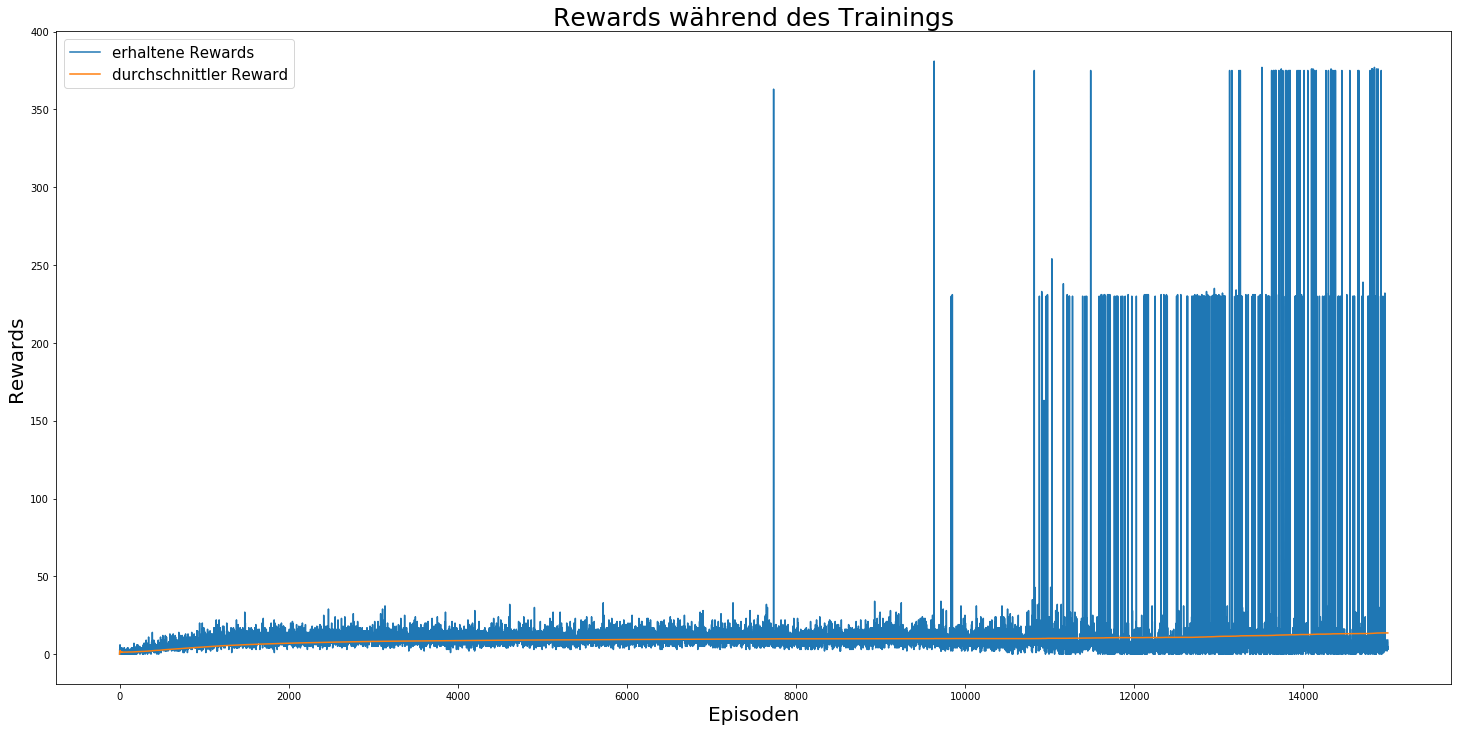

In [24]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Trainierten Agenten spielen lassen**

In [25]:
!ls "WEIGHTS/"

Breakout-v0_DQN_End.h5	     Breakout-v0_DQN_Ep_14849.h5
Breakout-v0_DQN_Ep_11646.h5  Breakout-v0_DQN_Ep_14850.h5
Breakout-v0_DQN_Ep_11647.h5  Breakout-v0_DQN_Ep_14870.h5
Breakout-v0_DQN_Ep_13679.h5  Breakout-v0_DQN_Ep_14871.h5
Breakout-v0_DQN_Ep_14848.h5  Breakout-v0_DQN_Ep_3508.h5


In [26]:
# Gewichte laden
WEIGHTS_PATH = "WEIGHTS/Pong-v0_DQN_Ep_14840.h5"
DQN.load_weights(filepath=WEIGHTS_PATH)

OSError: Unable to open file (unable to open file: name = 'WEIGHTS/Pong-v0_DQN_Ep_14840.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Rendering a Game

In [ ]:
import gym
from IPython import display
import matplotlib
%matplotlib inline

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(DQN.predict(state))
        state, reward, done, info = env.step(action)